# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

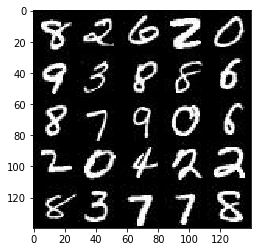

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

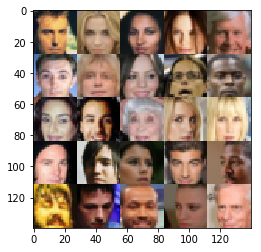

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/home/areej/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,[None,image_width, image_height, image_channels], name = 'real_input')
    z_input = tf.placeholder(tf.float32,[None, z_dim], name = 'z_input')
    learning_rate = tf.placeholder(tf.float32,[], name = 'learning_rate')

    return real_input, z_input, learning_rate


tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        c1 = tf.layers.conv2d(images, 56, 5, 2, 'SAME')
        c1 = tf.maximum(alpha*c1, c1)
        
        c2 = tf.layers.conv2d(c1, 112, 5, 2, 'SAME')
        c2 = tf.layers.batch_normalization(c2, training=True)
        c2 = tf.maximum(alpha*c2, c2)

        c3 = tf.layers.conv2d(c2, 224, 5, 2, 'SAME')
        c3 = tf.layers.batch_normalization(c3, training=True)
        c3 = tf.maximum(alpha*c3, c3)
        
        flat   = tf.reshape(c3, (-1, 4*4*224))
        logits = tf.layers.dense(flat, 1)
        
        logits = tf.layers.dropout(logits, rate=0.5)
        
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)


Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        
        full_layer = tf.layers.dense(z, 7*7*112)
        full_layer = tf.reshape(full_layer, (-1, 7, 7, 112))
        full_layer = tf.layers.batch_normalization(full_layer, training=is_train)
        full_layer = tf.maximum(alpha*full_layer, full_layer)
        
        c1 = tf.layers.conv2d_transpose(full_layer, 56, 5, 2, 'SAME')
        c1 = tf.layers.batch_normalization(c1, training=is_train)
        c1 = tf.maximum(alpha*c1, c1)
        
        c2 = tf.layers.conv2d_transpose(c1, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(c2)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE

"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
import numpy as np
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_ = generator(input_z, out_channel_dim, is_train = True)
    d_real, d_logits_real = discriminator(input_real, reuse = False)
    d_fake, d_logits_fake = discriminator(g_, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)


    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    image_channels = 1
    if(data_image_mode == 'RGB'):
        image_channels = 3
        
    image_width = data_shape[1]
    image_height = data_shape[2]
    
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    learn_rate = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, image_channels )
    d_train_operation, g_train_operation = model_opt(d_loss, g_loss, learn_rate, beta1)

    itt = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_im in get_batches(batch_size):
                # TODO: Train Model
                itt += 1
                batch_im *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_operation, feed_dict={input_real: batch_im, input_z: batch_z})
                _ = sess.run(g_train_operation, feed_dict={input_z: batch_z})                
                _ = sess.run(g_train_operation, feed_dict={input_z: batch_z})
                if (itt%100 == 0):
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                if (itt%10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_im})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("\nEpoch {}/{} and iteration {}".format(epoch_i+1, epochs, itt),
                          "The discriminator Loss is {:.3f}...".format(train_loss_d),
                              "The generator Loss is {:.3f}".format(train_loss_g))   
            #get the losses and print
            train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_im})
            train_loss_g = g_loss.eval({input_z: batch_z})
            print("\nEpoch {}/{}...".format(epoch_i+1, epochs),
                  "The discriminator Loss is {:.5f}...".format(train_loss_d),
                  "The generator Loss: {:.5f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.


Epoch 1/2 and iteration 10 The discriminator Loss is 3.761... The generator Loss is 0.378

Epoch 1/2 and iteration 20 The discriminator Loss is 2.846... The generator Loss is 0.149

Epoch 1/2 and iteration 30 The discriminator Loss is 2.663... The generator Loss is 0.136

Epoch 1/2 and iteration 40 The discriminator Loss is 2.206... The generator Loss is 0.255

Epoch 1/2 and iteration 50 The discriminator Loss is 2.185... The generator Loss is 0.265

Epoch 1/2 and iteration 60 The discriminator Loss is 2.103... The generator Loss is 0.268

Epoch 1/2 and iteration 70 The discriminator Loss is 1.876... The generator Loss is 0.364

Epoch 1/2 and iteration 80 The discriminator Loss is 1.852... The generator Loss is 0.336

Epoch 1/2 and iteration 90 The discriminator Loss is 1.753... The generator Loss is 0.580


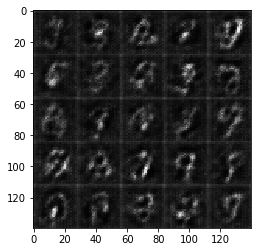


Epoch 1/2 and iteration 100 The discriminator Loss is 1.544... The generator Loss is 1.160

Epoch 1/2 and iteration 110 The discriminator Loss is 1.716... The generator Loss is 0.657

Epoch 1/2 and iteration 120 The discriminator Loss is 2.180... The generator Loss is 0.204

Epoch 1/2 and iteration 130 The discriminator Loss is 1.563... The generator Loss is 0.508

Epoch 1/2 and iteration 140 The discriminator Loss is 2.189... The generator Loss is 0.184

Epoch 1/2 and iteration 150 The discriminator Loss is 2.133... The generator Loss is 0.202

Epoch 1/2 and iteration 160 The discriminator Loss is 1.994... The generator Loss is 0.653

Epoch 1/2 and iteration 170 The discriminator Loss is 1.922... The generator Loss is 0.303

Epoch 1/2 and iteration 180 The discriminator Loss is 1.613... The generator Loss is 0.677

Epoch 1/2 and iteration 190 The discriminator Loss is 1.538... The generator Loss is 0.644


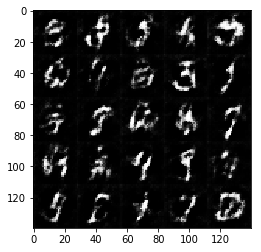


Epoch 1/2 and iteration 200 The discriminator Loss is 2.340... The generator Loss is 0.195

Epoch 1/2 and iteration 210 The discriminator Loss is 1.521... The generator Loss is 0.761

Epoch 1/2 and iteration 220 The discriminator Loss is 2.028... The generator Loss is 0.254

Epoch 1/2 and iteration 230 The discriminator Loss is 1.723... The generator Loss is 0.392

Epoch 1/2 and iteration 240 The discriminator Loss is 1.730... The generator Loss is 0.533

Epoch 1/2 and iteration 250 The discriminator Loss is 1.811... The generator Loss is 0.519

Epoch 1/2 and iteration 260 The discriminator Loss is 2.253... The generator Loss is 0.202

Epoch 1/2 and iteration 270 The discriminator Loss is 1.382... The generator Loss is 0.837

Epoch 1/2 and iteration 280 The discriminator Loss is 1.697... The generator Loss is 0.339

Epoch 1/2 and iteration 290 The discriminator Loss is 1.675... The generator Loss is 0.493


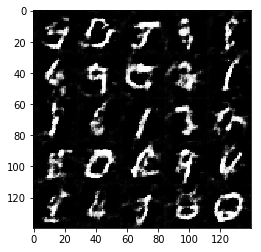


Epoch 1/2 and iteration 300 The discriminator Loss is 1.867... The generator Loss is 0.264

Epoch 1/2 and iteration 310 The discriminator Loss is 1.452... The generator Loss is 0.832

Epoch 1/2 and iteration 320 The discriminator Loss is 1.590... The generator Loss is 0.593

Epoch 1/2 and iteration 330 The discriminator Loss is 2.011... The generator Loss is 0.292

Epoch 1/2 and iteration 340 The discriminator Loss is 1.456... The generator Loss is 0.978

Epoch 1/2 and iteration 350 The discriminator Loss is 1.949... The generator Loss is 0.256

Epoch 1/2 and iteration 360 The discriminator Loss is 1.550... The generator Loss is 0.456

Epoch 1/2 and iteration 370 The discriminator Loss is 1.393... The generator Loss is 1.192

Epoch 1/2 and iteration 380 The discriminator Loss is 1.810... The generator Loss is 0.476

Epoch 1/2 and iteration 390 The discriminator Loss is 1.451... The generator Loss is 0.515


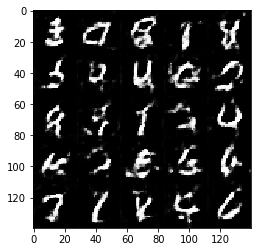


Epoch 1/2 and iteration 400 The discriminator Loss is 1.624... The generator Loss is 0.417

Epoch 1/2 and iteration 410 The discriminator Loss is 2.065... The generator Loss is 0.237

Epoch 1/2 and iteration 420 The discriminator Loss is 1.972... The generator Loss is 0.236

Epoch 1/2 and iteration 430 The discriminator Loss is 1.983... The generator Loss is 0.228

Epoch 1/2 and iteration 440 The discriminator Loss is 1.453... The generator Loss is 1.125

Epoch 1/2 and iteration 450 The discriminator Loss is 1.786... The generator Loss is 0.352

Epoch 1/2 and iteration 460 The discriminator Loss is 1.557... The generator Loss is 0.410

Epoch 1/2 and iteration 470 The discriminator Loss is 1.909... The generator Loss is 0.273

Epoch 1/2 and iteration 480 The discriminator Loss is 2.229... The generator Loss is 0.196

Epoch 1/2 and iteration 490 The discriminator Loss is 1.292... The generator Loss is 0.961


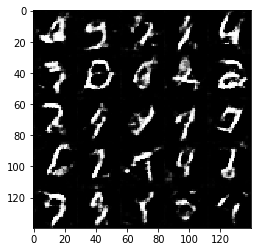


Epoch 1/2 and iteration 500 The discriminator Loss is 1.917... The generator Loss is 0.285

Epoch 1/2 and iteration 510 The discriminator Loss is 1.538... The generator Loss is 0.439

Epoch 1/2 and iteration 520 The discriminator Loss is 1.647... The generator Loss is 0.385

Epoch 1/2 and iteration 530 The discriminator Loss is 2.063... The generator Loss is 0.245

Epoch 1/2 and iteration 540 The discriminator Loss is 1.472... The generator Loss is 0.866

Epoch 1/2 and iteration 550 The discriminator Loss is 1.488... The generator Loss is 0.478

Epoch 1/2 and iteration 560 The discriminator Loss is 1.663... The generator Loss is 0.383

Epoch 1/2 and iteration 570 The discriminator Loss is 1.486... The generator Loss is 1.139

Epoch 1/2 and iteration 580 The discriminator Loss is 1.836... The generator Loss is 0.304

Epoch 1/2 and iteration 590 The discriminator Loss is 1.473... The generator Loss is 0.541


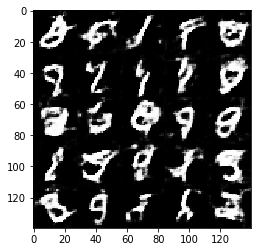


Epoch 1/2 and iteration 600 The discriminator Loss is 1.523... The generator Loss is 0.499

Epoch 1/2 and iteration 610 The discriminator Loss is 1.441... The generator Loss is 1.026

Epoch 1/2 and iteration 620 The discriminator Loss is 1.347... The generator Loss is 0.711

Epoch 1/2 and iteration 630 The discriminator Loss is 1.332... The generator Loss is 0.829

Epoch 1/2 and iteration 640 The discriminator Loss is 1.306... The generator Loss is 0.600

Epoch 1/2 and iteration 650 The discriminator Loss is 1.816... The generator Loss is 0.286

Epoch 1/2 and iteration 660 The discriminator Loss is 1.436... The generator Loss is 0.609

Epoch 1/2 and iteration 670 The discriminator Loss is 1.463... The generator Loss is 0.565

Epoch 1/2 and iteration 680 The discriminator Loss is 1.769... The generator Loss is 0.544

Epoch 1/2 and iteration 690 The discriminator Loss is 1.726... The generator Loss is 0.385


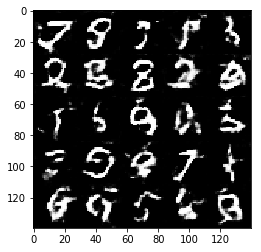


Epoch 1/2 and iteration 700 The discriminator Loss is 1.261... The generator Loss is 0.771

Epoch 1/2 and iteration 710 The discriminator Loss is 1.610... The generator Loss is 0.400

Epoch 1/2 and iteration 720 The discriminator Loss is 1.490... The generator Loss is 0.885

Epoch 1/2 and iteration 730 The discriminator Loss is 1.859... The generator Loss is 1.436

Epoch 1/2 and iteration 740 The discriminator Loss is 1.705... The generator Loss is 0.353

Epoch 1/2 and iteration 750 The discriminator Loss is 1.727... The generator Loss is 1.506

Epoch 1/2 and iteration 760 The discriminator Loss is 1.617... The generator Loss is 0.526

Epoch 1/2 and iteration 770 The discriminator Loss is 1.726... The generator Loss is 0.348

Epoch 1/2 and iteration 780 The discriminator Loss is 2.318... The generator Loss is 0.171

Epoch 1/2 and iteration 790 The discriminator Loss is 5.030... The generator Loss is 4.720


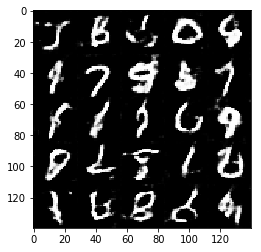


Epoch 1/2 and iteration 800 The discriminator Loss is 1.764... The generator Loss is 0.364

Epoch 1/2 and iteration 810 The discriminator Loss is 1.442... The generator Loss is 1.161

Epoch 1/2 and iteration 820 The discriminator Loss is 1.589... The generator Loss is 0.423

Epoch 1/2 and iteration 830 The discriminator Loss is 1.277... The generator Loss is 0.635

Epoch 1/2 and iteration 840 The discriminator Loss is 1.914... The generator Loss is 0.279

Epoch 1/2 and iteration 850 The discriminator Loss is 1.525... The generator Loss is 0.470

Epoch 1/2 and iteration 860 The discriminator Loss is 0.904... The generator Loss is 1.260

Epoch 1/2 and iteration 870 The discriminator Loss is 1.467... The generator Loss is 0.532

Epoch 1/2 and iteration 880 The discriminator Loss is 1.253... The generator Loss is 0.715

Epoch 1/2 and iteration 890 The discriminator Loss is 1.666... The generator Loss is 0.363


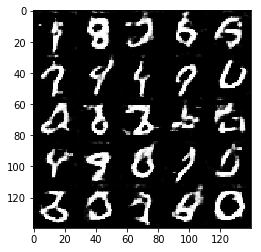


Epoch 1/2 and iteration 900 The discriminator Loss is 1.378... The generator Loss is 0.498

Epoch 1/2 and iteration 910 The discriminator Loss is 1.358... The generator Loss is 0.911

Epoch 1/2 and iteration 920 The discriminator Loss is 1.826... The generator Loss is 0.333

Epoch 1/2 and iteration 930 The discriminator Loss is 1.167... The generator Loss is 0.821

Epoch 1/2 and iteration 940 The discriminator Loss is 1.141... The generator Loss is 0.737

Epoch 1/2 and iteration 950 The discriminator Loss is 1.129... The generator Loss is 0.774

Epoch 1/2 and iteration 960 The discriminator Loss is 1.762... The generator Loss is 0.326

Epoch 1/2 and iteration 970 The discriminator Loss is 1.790... The generator Loss is 0.332

Epoch 1/2 and iteration 980 The discriminator Loss is 1.400... The generator Loss is 1.032

Epoch 1/2 and iteration 990 The discriminator Loss is 1.662... The generator Loss is 0.381


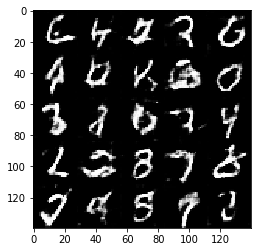


Epoch 1/2 and iteration 1000 The discriminator Loss is 1.946... The generator Loss is 2.919

Epoch 1/2 and iteration 1010 The discriminator Loss is 1.964... The generator Loss is 0.283

Epoch 1/2 and iteration 1020 The discriminator Loss is 1.856... The generator Loss is 0.296

Epoch 1/2 and iteration 1030 The discriminator Loss is 1.743... The generator Loss is 0.331

Epoch 1/2 and iteration 1040 The discriminator Loss is 1.729... The generator Loss is 0.446

Epoch 1/2 and iteration 1050 The discriminator Loss is 1.702... The generator Loss is 0.411

Epoch 1/2 and iteration 1060 The discriminator Loss is 1.272... The generator Loss is 1.233

Epoch 1/2 and iteration 1070 The discriminator Loss is 1.354... The generator Loss is 0.707

Epoch 1/2 and iteration 1080 The discriminator Loss is 1.306... The generator Loss is 0.600

Epoch 1/2 and iteration 1090 The discriminator Loss is 1.821... The generator Loss is 0.337


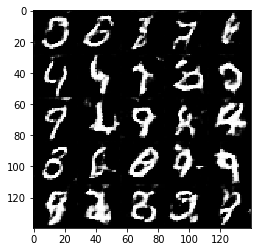


Epoch 1/2 and iteration 1100 The discriminator Loss is 1.842... The generator Loss is 0.300

Epoch 1/2 and iteration 1110 The discriminator Loss is 1.268... The generator Loss is 0.757

Epoch 1/2 and iteration 1120 The discriminator Loss is 1.574... The generator Loss is 0.477

Epoch 1/2 and iteration 1130 The discriminator Loss is 1.919... The generator Loss is 0.291

Epoch 1/2 and iteration 1140 The discriminator Loss is 1.260... The generator Loss is 1.691

Epoch 1/2 and iteration 1150 The discriminator Loss is 1.497... The generator Loss is 0.466

Epoch 1/2 and iteration 1160 The discriminator Loss is 1.159... The generator Loss is 0.893

Epoch 1/2 and iteration 1170 The discriminator Loss is 2.388... The generator Loss is 0.195

Epoch 1/2 and iteration 1180 The discriminator Loss is 1.740... The generator Loss is 0.911

Epoch 1/2 and iteration 1190 The discriminator Loss is 2.772... The generator Loss is 0.140


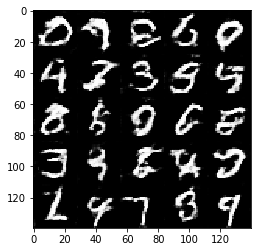


Epoch 1/2 and iteration 1200 The discriminator Loss is 1.808... The generator Loss is 0.331

Epoch 1/2 and iteration 1210 The discriminator Loss is 1.116... The generator Loss is 0.833

Epoch 1/2 and iteration 1220 The discriminator Loss is 2.368... The generator Loss is 0.188

Epoch 1/2 and iteration 1230 The discriminator Loss is 1.321... The generator Loss is 0.685

Epoch 1/2 and iteration 1240 The discriminator Loss is 1.353... The generator Loss is 0.732

Epoch 1/2 and iteration 1250 The discriminator Loss is 1.341... The generator Loss is 0.563

Epoch 1/2 and iteration 1260 The discriminator Loss is 2.214... The generator Loss is 0.275

Epoch 1/2 and iteration 1270 The discriminator Loss is 1.248... The generator Loss is 0.689

Epoch 1/2 and iteration 1280 The discriminator Loss is 1.716... The generator Loss is 0.366

Epoch 1/2 and iteration 1290 The discriminator Loss is 3.287... The generator Loss is 0.072


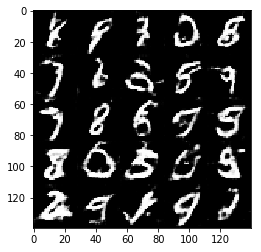


Epoch 1/2 and iteration 1300 The discriminator Loss is 1.281... The generator Loss is 1.775

Epoch 1/2 and iteration 1310 The discriminator Loss is 1.391... The generator Loss is 0.504

Epoch 1/2 and iteration 1320 The discriminator Loss is 1.964... The generator Loss is 0.314

Epoch 1/2 and iteration 1330 The discriminator Loss is 1.778... The generator Loss is 0.331

Epoch 1/2 and iteration 1340 The discriminator Loss is 1.501... The generator Loss is 0.566

Epoch 1/2 and iteration 1350 The discriminator Loss is 2.390... The generator Loss is 0.187

Epoch 1/2 and iteration 1360 The discriminator Loss is 2.390... The generator Loss is 0.220

Epoch 1/2 and iteration 1370 The discriminator Loss is 1.213... The generator Loss is 0.627

Epoch 1/2 and iteration 1380 The discriminator Loss is 1.699... The generator Loss is 0.348

Epoch 1/2 and iteration 1390 The discriminator Loss is 2.212... The generator Loss is 0.253


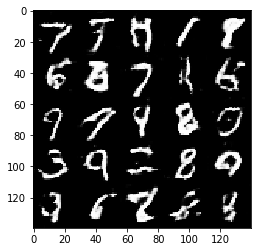


Epoch 1/2 and iteration 1400 The discriminator Loss is 1.623... The generator Loss is 0.390

Epoch 1/2 and iteration 1410 The discriminator Loss is 1.063... The generator Loss is 0.897

Epoch 1/2 and iteration 1420 The discriminator Loss is 1.512... The generator Loss is 0.512

Epoch 1/2 and iteration 1430 The discriminator Loss is 2.215... The generator Loss is 0.219

Epoch 1/2 and iteration 1440 The discriminator Loss is 2.092... The generator Loss is 0.243

Epoch 1/2 and iteration 1450 The discriminator Loss is 1.232... The generator Loss is 0.705

Epoch 1/2 and iteration 1460 The discriminator Loss is 1.675... The generator Loss is 0.623

Epoch 1/2 and iteration 1470 The discriminator Loss is 1.785... The generator Loss is 0.442

Epoch 1/2 and iteration 1480 The discriminator Loss is 1.114... The generator Loss is 0.861

Epoch 1/2 and iteration 1490 The discriminator Loss is 1.037... The generator Loss is 0.841


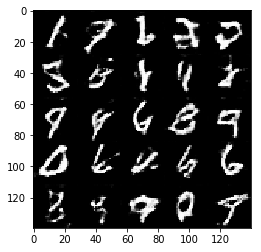


Epoch 1/2 and iteration 1500 The discriminator Loss is 1.028... The generator Loss is 0.943

Epoch 1/2 and iteration 1510 The discriminator Loss is 1.601... The generator Loss is 0.419

Epoch 1/2 and iteration 1520 The discriminator Loss is 2.018... The generator Loss is 0.253

Epoch 1/2 and iteration 1530 The discriminator Loss is 1.604... The generator Loss is 0.531

Epoch 1/2 and iteration 1540 The discriminator Loss is 2.194... The generator Loss is 0.216

Epoch 1/2 and iteration 1550 The discriminator Loss is 2.045... The generator Loss is 2.523

Epoch 1/2 and iteration 1560 The discriminator Loss is 1.578... The generator Loss is 0.512

Epoch 1/2 and iteration 1570 The discriminator Loss is 1.483... The generator Loss is 0.687

Epoch 1/2 and iteration 1580 The discriminator Loss is 1.212... The generator Loss is 0.670

Epoch 1/2 and iteration 1590 The discriminator Loss is 1.803... The generator Loss is 0.316


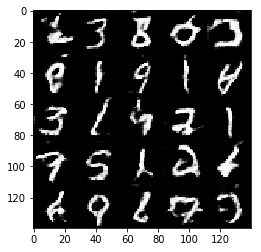


Epoch 1/2 and iteration 1600 The discriminator Loss is 1.428... The generator Loss is 0.527

Epoch 1/2 and iteration 1610 The discriminator Loss is 1.197... The generator Loss is 0.632

Epoch 1/2 and iteration 1620 The discriminator Loss is 1.930... The generator Loss is 0.278

Epoch 1/2 and iteration 1630 The discriminator Loss is 0.857... The generator Loss is 1.082

Epoch 1/2 and iteration 1640 The discriminator Loss is 1.630... The generator Loss is 0.573

Epoch 1/2 and iteration 1650 The discriminator Loss is 2.389... The generator Loss is 0.169

Epoch 1/2 and iteration 1660 The discriminator Loss is 1.779... The generator Loss is 0.345

Epoch 1/2 and iteration 1670 The discriminator Loss is 1.341... The generator Loss is 0.957

Epoch 1/2 and iteration 1680 The discriminator Loss is 1.034... The generator Loss is 0.847

Epoch 1/2 and iteration 1690 The discriminator Loss is 2.497... The generator Loss is 0.174


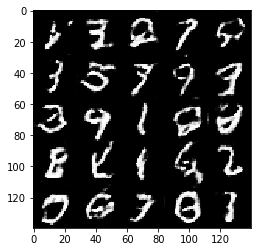


Epoch 1/2 and iteration 1700 The discriminator Loss is 1.779... The generator Loss is 0.356

Epoch 1/2 and iteration 1710 The discriminator Loss is 1.333... The generator Loss is 0.569

Epoch 1/2 and iteration 1720 The discriminator Loss is 2.049... The generator Loss is 0.234

Epoch 1/2 and iteration 1730 The discriminator Loss is 1.980... The generator Loss is 0.285

Epoch 1/2 and iteration 1740 The discriminator Loss is 1.287... The generator Loss is 0.888

Epoch 1/2 and iteration 1750 The discriminator Loss is 1.284... The generator Loss is 0.645

Epoch 1/2 and iteration 1760 The discriminator Loss is 1.787... The generator Loss is 0.454

Epoch 1/2 and iteration 1770 The discriminator Loss is 1.046... The generator Loss is 0.847

Epoch 1/2 and iteration 1780 The discriminator Loss is 1.292... The generator Loss is 0.600

Epoch 1/2 and iteration 1790 The discriminator Loss is 2.123... The generator Loss is 0.210


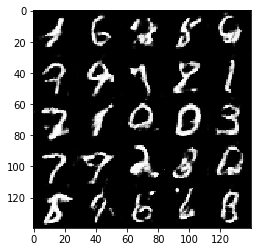


Epoch 1/2 and iteration 1800 The discriminator Loss is 1.694... The generator Loss is 0.359

Epoch 1/2 and iteration 1810 The discriminator Loss is 2.072... The generator Loss is 0.213

Epoch 1/2 and iteration 1820 The discriminator Loss is 1.962... The generator Loss is 0.306

Epoch 1/2 and iteration 1830 The discriminator Loss is 0.777... The generator Loss is 1.477

Epoch 1/2 and iteration 1840 The discriminator Loss is 2.030... The generator Loss is 0.248

Epoch 1/2 and iteration 1850 The discriminator Loss is 1.594... The generator Loss is 0.823

Epoch 1/2 and iteration 1860 The discriminator Loss is 1.071... The generator Loss is 2.432

Epoch 1/2 and iteration 1870 The discriminator Loss is 1.093... The generator Loss is 0.828

Epoch 1/2 and iteration 1880 The discriminator Loss is 1.005... The generator Loss is 1.103

Epoch 1/2 and iteration 1890 The discriminator Loss is 1.243... The generator Loss is 0.624


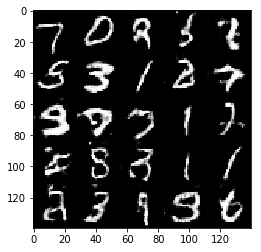


Epoch 1/2 and iteration 1900 The discriminator Loss is 1.141... The generator Loss is 0.721

Epoch 1/2 and iteration 1910 The discriminator Loss is 1.599... The generator Loss is 0.438

Epoch 1/2 and iteration 1920 The discriminator Loss is 1.320... The generator Loss is 0.595

Epoch 1/2 and iteration 1930 The discriminator Loss is 1.194... The generator Loss is 0.639

Epoch 1/2 and iteration 1940 The discriminator Loss is 0.945... The generator Loss is 0.957

Epoch 1/2 and iteration 1950 The discriminator Loss is 1.325... The generator Loss is 0.874

Epoch 1/2 and iteration 1960 The discriminator Loss is 1.543... The generator Loss is 0.447

Epoch 1/2 and iteration 1970 The discriminator Loss is 3.164... The generator Loss is 0.076

Epoch 1/2 and iteration 1980 The discriminator Loss is 2.170... The generator Loss is 0.242

Epoch 1/2 and iteration 1990 The discriminator Loss is 1.321... The generator Loss is 0.585


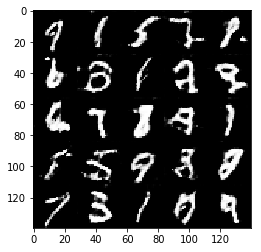


Epoch 1/2 and iteration 2000 The discriminator Loss is 1.543... The generator Loss is 0.451

Epoch 1/2 and iteration 2010 The discriminator Loss is 2.549... The generator Loss is 0.155

Epoch 1/2 and iteration 2020 The discriminator Loss is 1.531... The generator Loss is 0.522

Epoch 1/2 and iteration 2030 The discriminator Loss is 1.737... The generator Loss is 0.390

Epoch 1/2 and iteration 2040 The discriminator Loss is 1.476... The generator Loss is 0.455

Epoch 1/2 and iteration 2050 The discriminator Loss is 1.297... The generator Loss is 0.662

Epoch 1/2 and iteration 2060 The discriminator Loss is 1.585... The generator Loss is 0.408

Epoch 1/2 and iteration 2070 The discriminator Loss is 1.011... The generator Loss is 0.902

Epoch 1/2 and iteration 2080 The discriminator Loss is 2.014... The generator Loss is 0.286

Epoch 1/2 and iteration 2090 The discriminator Loss is 1.407... The generator Loss is 0.533


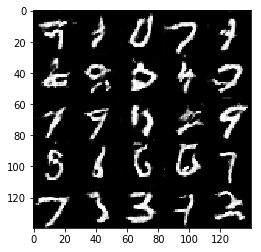


Epoch 1/2 and iteration 2100 The discriminator Loss is 1.591... The generator Loss is 0.492

Epoch 1/2 and iteration 2110 The discriminator Loss is 3.072... The generator Loss is 0.087

Epoch 1/2 and iteration 2120 The discriminator Loss is 1.538... The generator Loss is 0.441

Epoch 1/2 and iteration 2130 The discriminator Loss is 1.289... The generator Loss is 0.555

Epoch 1/2 and iteration 2140 The discriminator Loss is 2.136... The generator Loss is 0.240

Epoch 1/2 and iteration 2150 The discriminator Loss is 1.596... The generator Loss is 0.437

Epoch 1/2 and iteration 2160 The discriminator Loss is 2.379... The generator Loss is 0.210

Epoch 1/2 and iteration 2170 The discriminator Loss is 1.826... The generator Loss is 0.339

Epoch 1/2 and iteration 2180 The discriminator Loss is 1.231... The generator Loss is 0.654

Epoch 1/2 and iteration 2190 The discriminator Loss is 1.814... The generator Loss is 0.332


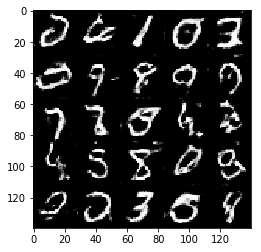


Epoch 1/2 and iteration 2200 The discriminator Loss is 2.721... The generator Loss is 0.161

Epoch 1/2 and iteration 2210 The discriminator Loss is 2.211... The generator Loss is 0.219

Epoch 1/2 and iteration 2220 The discriminator Loss is 1.405... The generator Loss is 0.494

Epoch 1/2 and iteration 2230 The discriminator Loss is 2.317... The generator Loss is 0.181

Epoch 1/2 and iteration 2240 The discriminator Loss is 1.271... The generator Loss is 0.641

Epoch 1/2 and iteration 2250 The discriminator Loss is 0.921... The generator Loss is 1.199

Epoch 1/2 and iteration 2260 The discriminator Loss is 1.327... The generator Loss is 0.614

Epoch 1/2 and iteration 2270 The discriminator Loss is 1.539... The generator Loss is 0.430

Epoch 1/2 and iteration 2280 The discriminator Loss is 1.730... The generator Loss is 0.368

Epoch 1/2 and iteration 2290 The discriminator Loss is 1.186... The generator Loss is 0.764


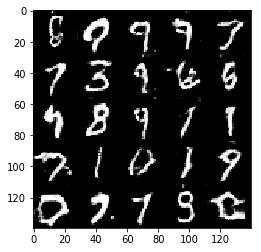


Epoch 1/2 and iteration 2300 The discriminator Loss is 1.663... The generator Loss is 0.379

Epoch 1/2 and iteration 2310 The discriminator Loss is 1.243... The generator Loss is 0.715

Epoch 1/2 and iteration 2320 The discriminator Loss is 1.709... The generator Loss is 0.397

Epoch 1/2 and iteration 2330 The discriminator Loss is 1.473... The generator Loss is 0.482

Epoch 1/2 and iteration 2340 The discriminator Loss is 1.371... The generator Loss is 2.044

Epoch 1/2 and iteration 2350 The discriminator Loss is 1.260... The generator Loss is 0.740

Epoch 1/2 and iteration 2360 The discriminator Loss is 1.642... The generator Loss is 0.356

Epoch 1/2 and iteration 2370 The discriminator Loss is 1.887... The generator Loss is 0.382

Epoch 1/2 and iteration 2380 The discriminator Loss is 1.298... The generator Loss is 0.660

Epoch 1/2 and iteration 2390 The discriminator Loss is 1.976... The generator Loss is 0.316


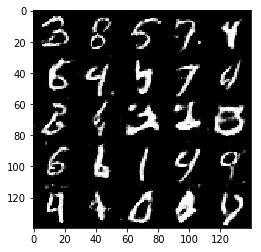


Epoch 1/2 and iteration 2400 The discriminator Loss is 2.333... The generator Loss is 0.178

Epoch 1/2 and iteration 2410 The discriminator Loss is 2.043... The generator Loss is 0.287

Epoch 1/2 and iteration 2420 The discriminator Loss is 1.984... The generator Loss is 0.321

Epoch 1/2 and iteration 2430 The discriminator Loss is 1.323... The generator Loss is 0.895

Epoch 1/2 and iteration 2440 The discriminator Loss is 1.455... The generator Loss is 0.505

Epoch 1/2 and iteration 2450 The discriminator Loss is 1.414... The generator Loss is 0.641

Epoch 1/2 and iteration 2460 The discriminator Loss is 1.930... The generator Loss is 0.259

Epoch 1/2 and iteration 2470 The discriminator Loss is 1.764... The generator Loss is 0.358

Epoch 1/2 and iteration 2480 The discriminator Loss is 0.823... The generator Loss is 1.219

Epoch 1/2 and iteration 2490 The discriminator Loss is 1.777... The generator Loss is 0.320


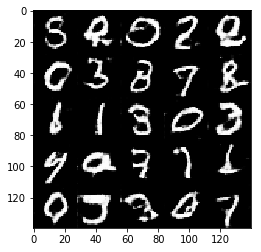


Epoch 1/2 and iteration 2500 The discriminator Loss is 1.643... The generator Loss is 0.396

Epoch 1/2 and iteration 2510 The discriminator Loss is 1.179... The generator Loss is 0.754

Epoch 1/2 and iteration 2520 The discriminator Loss is 2.129... The generator Loss is 0.334

Epoch 1/2 and iteration 2530 The discriminator Loss is 1.162... The generator Loss is 0.707

Epoch 1/2 and iteration 2540 The discriminator Loss is 2.100... The generator Loss is 0.289

Epoch 1/2 and iteration 2550 The discriminator Loss is 1.061... The generator Loss is 0.901

Epoch 1/2 and iteration 2560 The discriminator Loss is 1.631... The generator Loss is 0.479

Epoch 1/2 and iteration 2570 The discriminator Loss is 2.483... The generator Loss is 0.181

Epoch 1/2 and iteration 2580 The discriminator Loss is 1.296... The generator Loss is 0.678

Epoch 1/2 and iteration 2590 The discriminator Loss is 1.626... The generator Loss is 0.395


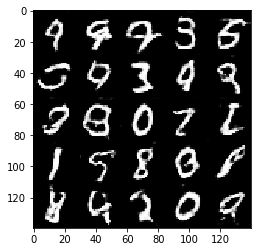


Epoch 1/2 and iteration 2600 The discriminator Loss is 2.094... The generator Loss is 0.227

Epoch 1/2 and iteration 2610 The discriminator Loss is 1.388... The generator Loss is 0.581

Epoch 1/2 and iteration 2620 The discriminator Loss is 1.101... The generator Loss is 0.772

Epoch 1/2 and iteration 2630 The discriminator Loss is 2.128... The generator Loss is 0.259

Epoch 1/2 and iteration 2640 The discriminator Loss is 1.594... The generator Loss is 0.413

Epoch 1/2 and iteration 2650 The discriminator Loss is 0.762... The generator Loss is 1.470

Epoch 1/2 and iteration 2660 The discriminator Loss is 1.138... The generator Loss is 0.704

Epoch 1/2 and iteration 2670 The discriminator Loss is 0.978... The generator Loss is 0.965

Epoch 1/2 and iteration 2680 The discriminator Loss is 1.676... The generator Loss is 0.371

Epoch 1/2 and iteration 2690 The discriminator Loss is 1.770... The generator Loss is 0.334


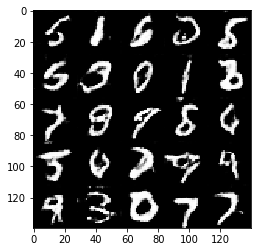


Epoch 1/2 and iteration 2700 The discriminator Loss is 1.071... The generator Loss is 0.803

Epoch 1/2 and iteration 2710 The discriminator Loss is 1.481... The generator Loss is 0.463

Epoch 1/2 and iteration 2720 The discriminator Loss is 1.095... The generator Loss is 0.905

Epoch 1/2 and iteration 2730 The discriminator Loss is 1.729... The generator Loss is 0.430

Epoch 1/2 and iteration 2740 The discriminator Loss is 2.811... The generator Loss is 0.138

Epoch 1/2 and iteration 2750 The discriminator Loss is 1.360... The generator Loss is 0.562

Epoch 1/2 and iteration 2760 The discriminator Loss is 1.188... The generator Loss is 0.714

Epoch 1/2 and iteration 2770 The discriminator Loss is 1.582... The generator Loss is 0.481

Epoch 1/2 and iteration 2780 The discriminator Loss is 1.588... The generator Loss is 0.476

Epoch 1/2 and iteration 2790 The discriminator Loss is 2.242... The generator Loss is 0.221


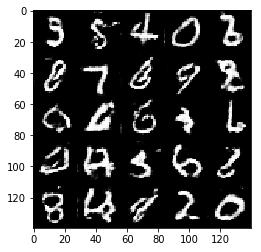


Epoch 1/2 and iteration 2800 The discriminator Loss is 0.907... The generator Loss is 1.051

Epoch 1/2 and iteration 2810 The discriminator Loss is 1.311... The generator Loss is 0.554

Epoch 1/2 and iteration 2820 The discriminator Loss is 1.360... The generator Loss is 0.642

Epoch 1/2 and iteration 2830 The discriminator Loss is 1.381... The generator Loss is 0.539

Epoch 1/2 and iteration 2840 The discriminator Loss is 1.539... The generator Loss is 0.530

Epoch 1/2 and iteration 2850 The discriminator Loss is 1.137... The generator Loss is 0.708

Epoch 1/2 and iteration 2860 The discriminator Loss is 1.505... The generator Loss is 0.483

Epoch 1/2 and iteration 2870 The discriminator Loss is 1.519... The generator Loss is 0.481

Epoch 1/2 and iteration 2880 The discriminator Loss is 1.582... The generator Loss is 0.456

Epoch 1/2 and iteration 2890 The discriminator Loss is 0.778... The generator Loss is 1.650


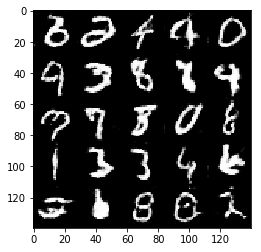


Epoch 1/2 and iteration 2900 The discriminator Loss is 2.452... The generator Loss is 0.230

Epoch 1/2 and iteration 2910 The discriminator Loss is 1.238... The generator Loss is 0.614

Epoch 1/2 and iteration 2920 The discriminator Loss is 1.688... The generator Loss is 0.417

Epoch 1/2 and iteration 2930 The discriminator Loss is 1.779... The generator Loss is 0.335

Epoch 1/2 and iteration 2940 The discriminator Loss is 1.001... The generator Loss is 0.918

Epoch 1/2 and iteration 2950 The discriminator Loss is 1.478... The generator Loss is 0.621

Epoch 1/2 and iteration 2960 The discriminator Loss is 2.176... The generator Loss is 0.260

Epoch 1/2 and iteration 2970 The discriminator Loss is 1.448... The generator Loss is 0.476

Epoch 1/2 and iteration 2980 The discriminator Loss is 1.100... The generator Loss is 0.856

Epoch 1/2 and iteration 2990 The discriminator Loss is 1.216... The generator Loss is 0.621


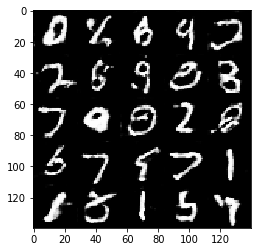


Epoch 1/2 and iteration 3000 The discriminator Loss is 0.838... The generator Loss is 1.009

Epoch 1/2 and iteration 3010 The discriminator Loss is 1.463... The generator Loss is 0.835

Epoch 1/2 and iteration 3020 The discriminator Loss is 1.277... The generator Loss is 0.658

Epoch 1/2 and iteration 3030 The discriminator Loss is 0.932... The generator Loss is 1.217

Epoch 1/2 and iteration 3040 The discriminator Loss is 1.197... The generator Loss is 0.606

Epoch 1/2 and iteration 3050 The discriminator Loss is 2.058... The generator Loss is 0.283

Epoch 1/2 and iteration 3060 The discriminator Loss is 1.587... The generator Loss is 0.398

Epoch 1/2 and iteration 3070 The discriminator Loss is 1.098... The generator Loss is 0.793

Epoch 1/2 and iteration 3080 The discriminator Loss is 1.325... The generator Loss is 0.757

Epoch 1/2 and iteration 3090 The discriminator Loss is 1.109... The generator Loss is 0.847


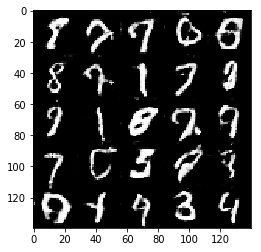


Epoch 1/2 and iteration 3100 The discriminator Loss is 1.567... The generator Loss is 0.497

Epoch 1/2 and iteration 3110 The discriminator Loss is 2.116... The generator Loss is 0.256

Epoch 1/2 and iteration 3120 The discriminator Loss is 2.116... The generator Loss is 0.243

Epoch 1/2 and iteration 3130 The discriminator Loss is 1.158... The generator Loss is 0.840

Epoch 1/2 and iteration 3140 The discriminator Loss is 2.371... The generator Loss is 0.254

Epoch 1/2 and iteration 3150 The discriminator Loss is 0.833... The generator Loss is 1.492

Epoch 1/2 and iteration 3160 The discriminator Loss is 1.125... The generator Loss is 0.753

Epoch 1/2 and iteration 3170 The discriminator Loss is 1.279... The generator Loss is 0.616

Epoch 1/2 and iteration 3180 The discriminator Loss is 0.680... The generator Loss is 1.621

Epoch 1/2 and iteration 3190 The discriminator Loss is 1.969... The generator Loss is 0.292


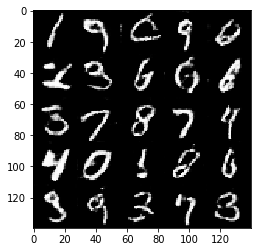


Epoch 1/2 and iteration 3200 The discriminator Loss is 1.661... The generator Loss is 0.432

Epoch 1/2 and iteration 3210 The discriminator Loss is 1.709... The generator Loss is 0.329

Epoch 1/2 and iteration 3220 The discriminator Loss is 2.332... The generator Loss is 0.227

Epoch 1/2 and iteration 3230 The discriminator Loss is 0.985... The generator Loss is 0.996

Epoch 1/2 and iteration 3240 The discriminator Loss is 1.025... The generator Loss is 1.035

Epoch 1/2 and iteration 3250 The discriminator Loss is 1.630... The generator Loss is 0.402

Epoch 1/2 and iteration 3260 The discriminator Loss is 0.994... The generator Loss is 0.934

Epoch 1/2 and iteration 3270 The discriminator Loss is 1.309... The generator Loss is 0.630

Epoch 1/2 and iteration 3280 The discriminator Loss is 1.815... The generator Loss is 0.383

Epoch 1/2 and iteration 3290 The discriminator Loss is 0.969... The generator Loss is 0.959


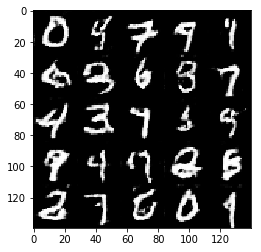


Epoch 1/2 and iteration 3300 The discriminator Loss is 1.430... The generator Loss is 0.522

Epoch 1/2 and iteration 3310 The discriminator Loss is 1.662... The generator Loss is 0.375

Epoch 1/2 and iteration 3320 The discriminator Loss is 1.369... The generator Loss is 0.608

Epoch 1/2 and iteration 3330 The discriminator Loss is 0.840... The generator Loss is 1.102

Epoch 1/2 and iteration 3340 The discriminator Loss is 0.922... The generator Loss is 1.863

Epoch 1/2 and iteration 3350 The discriminator Loss is 1.603... The generator Loss is 0.538

Epoch 1/2 and iteration 3360 The discriminator Loss is 0.974... The generator Loss is 0.913

Epoch 1/2 and iteration 3370 The discriminator Loss is 1.191... The generator Loss is 0.696

Epoch 1/2 and iteration 3380 The discriminator Loss is 1.373... The generator Loss is 0.560

Epoch 1/2 and iteration 3390 The discriminator Loss is 1.570... The generator Loss is 0.415


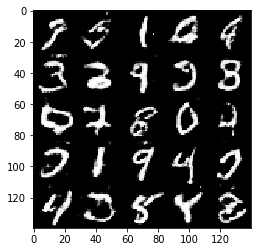


Epoch 1/2 and iteration 3400 The discriminator Loss is 1.022... The generator Loss is 0.786

Epoch 1/2 and iteration 3410 The discriminator Loss is 1.419... The generator Loss is 0.547

Epoch 1/2 and iteration 3420 The discriminator Loss is 2.027... The generator Loss is 0.308

Epoch 1/2 and iteration 3430 The discriminator Loss is 2.377... The generator Loss is 0.174

Epoch 1/2 and iteration 3440 The discriminator Loss is 1.494... The generator Loss is 1.480

Epoch 1/2 and iteration 3450 The discriminator Loss is 1.645... The generator Loss is 3.271

Epoch 1/2 and iteration 3460 The discriminator Loss is 1.418... The generator Loss is 0.767

Epoch 1/2 and iteration 3470 The discriminator Loss is 1.039... The generator Loss is 0.912

Epoch 1/2 and iteration 3480 The discriminator Loss is 1.843... The generator Loss is 0.337

Epoch 1/2 and iteration 3490 The discriminator Loss is 1.772... The generator Loss is 0.422


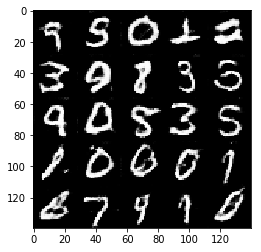


Epoch 1/2 and iteration 3500 The discriminator Loss is 1.507... The generator Loss is 1.936

Epoch 1/2 and iteration 3510 The discriminator Loss is 1.623... The generator Loss is 0.396

Epoch 1/2 and iteration 3520 The discriminator Loss is 1.182... The generator Loss is 0.668

Epoch 1/2 and iteration 3530 The discriminator Loss is 1.770... The generator Loss is 0.488

Epoch 1/2 and iteration 3540 The discriminator Loss is 1.334... The generator Loss is 0.569

Epoch 1/2 and iteration 3550 The discriminator Loss is 1.008... The generator Loss is 1.311

Epoch 1/2 and iteration 3560 The discriminator Loss is 1.549... The generator Loss is 0.426

Epoch 1/2 and iteration 3570 The discriminator Loss is 1.960... The generator Loss is 0.257

Epoch 1/2 and iteration 3580 The discriminator Loss is 1.269... The generator Loss is 0.669

Epoch 1/2 and iteration 3590 The discriminator Loss is 1.072... The generator Loss is 0.950


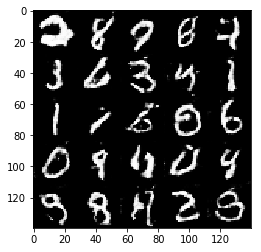


Epoch 1/2 and iteration 3600 The discriminator Loss is 1.565... The generator Loss is 0.514

Epoch 1/2 and iteration 3610 The discriminator Loss is 1.068... The generator Loss is 0.881

Epoch 1/2 and iteration 3620 The discriminator Loss is 1.895... The generator Loss is 0.322

Epoch 1/2 and iteration 3630 The discriminator Loss is 1.533... The generator Loss is 0.464

Epoch 1/2 and iteration 3640 The discriminator Loss is 1.531... The generator Loss is 0.546

Epoch 1/2 and iteration 3650 The discriminator Loss is 1.513... The generator Loss is 0.536

Epoch 1/2 and iteration 3660 The discriminator Loss is 1.765... The generator Loss is 0.356

Epoch 1/2 and iteration 3670 The discriminator Loss is 1.518... The generator Loss is 0.509

Epoch 1/2 and iteration 3680 The discriminator Loss is 1.864... The generator Loss is 0.327

Epoch 1/2 and iteration 3690 The discriminator Loss is 1.624... The generator Loss is 0.454


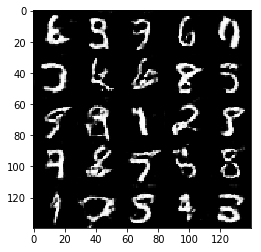


Epoch 1/2 and iteration 3700 The discriminator Loss is 1.516... The generator Loss is 0.512

Epoch 1/2 and iteration 3710 The discriminator Loss is 1.871... The generator Loss is 0.269

Epoch 1/2 and iteration 3720 The discriminator Loss is 1.679... The generator Loss is 0.364

Epoch 1/2 and iteration 3730 The discriminator Loss is 0.963... The generator Loss is 0.983

Epoch 1/2 and iteration 3740 The discriminator Loss is 1.349... The generator Loss is 0.561

Epoch 1/2 and iteration 3750 The discriminator Loss is 1.001... The generator Loss is 0.949

Epoch 1/2... The discriminator Loss is 1.00076... The generator Loss: 0.94927

Epoch 2/2 and iteration 3760 The discriminator Loss is 1.050... The generator Loss is 0.804

Epoch 2/2 and iteration 3770 The discriminator Loss is 2.054... The generator Loss is 0.286

Epoch 2/2 and iteration 3780 The discriminator Loss is 1.118... The generator Loss is 0.760

Epoch 2/2 and iteration 3790 The discriminator Loss is 1.211... The generator Loss 

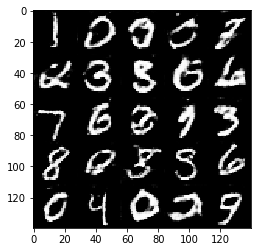


Epoch 2/2 and iteration 3800 The discriminator Loss is 1.271... The generator Loss is 0.595

Epoch 2/2 and iteration 3810 The discriminator Loss is 0.783... The generator Loss is 1.990

Epoch 2/2 and iteration 3820 The discriminator Loss is 2.394... The generator Loss is 0.242

Epoch 2/2 and iteration 3830 The discriminator Loss is 2.155... The generator Loss is 0.235

Epoch 2/2 and iteration 3840 The discriminator Loss is 0.795... The generator Loss is 1.507

Epoch 2/2 and iteration 3850 The discriminator Loss is 1.140... The generator Loss is 0.771

Epoch 2/2 and iteration 3860 The discriminator Loss is 0.823... The generator Loss is 1.261

Epoch 2/2 and iteration 3870 The discriminator Loss is 0.800... The generator Loss is 1.347

Epoch 2/2 and iteration 3880 The discriminator Loss is 1.989... The generator Loss is 0.293

Epoch 2/2 and iteration 3890 The discriminator Loss is 1.499... The generator Loss is 0.490


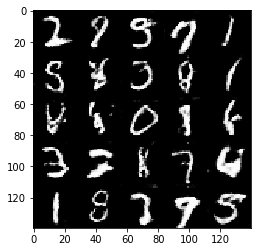


Epoch 2/2 and iteration 3900 The discriminator Loss is 1.916... The generator Loss is 0.266

Epoch 2/2 and iteration 3910 The discriminator Loss is 1.391... The generator Loss is 0.572

Epoch 2/2 and iteration 3920 The discriminator Loss is 1.093... The generator Loss is 0.780

Epoch 2/2 and iteration 3930 The discriminator Loss is 1.046... The generator Loss is 0.996

Epoch 2/2 and iteration 3940 The discriminator Loss is 1.820... The generator Loss is 0.345

Epoch 2/2 and iteration 3950 The discriminator Loss is 1.432... The generator Loss is 0.532

Epoch 2/2 and iteration 3960 The discriminator Loss is 1.409... The generator Loss is 0.668

Epoch 2/2 and iteration 3970 The discriminator Loss is 0.713... The generator Loss is 1.484

Epoch 2/2 and iteration 3980 The discriminator Loss is 1.265... The generator Loss is 0.621

Epoch 2/2 and iteration 3990 The discriminator Loss is 1.202... The generator Loss is 0.660


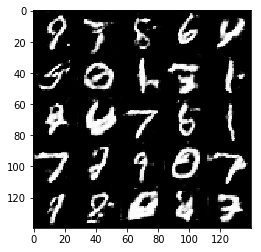


Epoch 2/2 and iteration 4000 The discriminator Loss is 1.618... The generator Loss is 0.432

Epoch 2/2 and iteration 4010 The discriminator Loss is 1.575... The generator Loss is 0.406

Epoch 2/2 and iteration 4020 The discriminator Loss is 1.573... The generator Loss is 0.482

Epoch 2/2 and iteration 4030 The discriminator Loss is 1.524... The generator Loss is 0.501

Epoch 2/2 and iteration 4040 The discriminator Loss is 1.551... The generator Loss is 0.432

Epoch 2/2 and iteration 4050 The discriminator Loss is 1.795... The generator Loss is 0.375

Epoch 2/2 and iteration 4060 The discriminator Loss is 1.443... The generator Loss is 0.432

Epoch 2/2 and iteration 4070 The discriminator Loss is 1.657... The generator Loss is 0.396

Epoch 2/2 and iteration 4080 The discriminator Loss is 1.564... The generator Loss is 0.507

Epoch 2/2 and iteration 4090 The discriminator Loss is 1.718... The generator Loss is 0.368


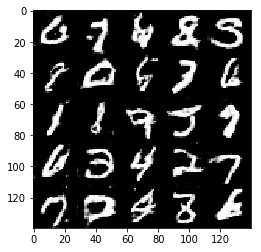


Epoch 2/2 and iteration 4100 The discriminator Loss is 0.889... The generator Loss is 1.014

Epoch 2/2 and iteration 4110 The discriminator Loss is 1.077... The generator Loss is 0.817

Epoch 2/2 and iteration 4120 The discriminator Loss is 2.144... The generator Loss is 0.272

Epoch 2/2 and iteration 4130 The discriminator Loss is 1.150... The generator Loss is 0.791

Epoch 2/2 and iteration 4140 The discriminator Loss is 1.272... The generator Loss is 0.595

Epoch 2/2 and iteration 4150 The discriminator Loss is 1.245... The generator Loss is 0.665

Epoch 2/2 and iteration 4160 The discriminator Loss is 1.062... The generator Loss is 0.735

Epoch 2/2 and iteration 4170 The discriminator Loss is 0.818... The generator Loss is 1.166

Epoch 2/2 and iteration 4180 The discriminator Loss is 2.423... The generator Loss is 0.186

Epoch 2/2 and iteration 4190 The discriminator Loss is 0.972... The generator Loss is 0.843


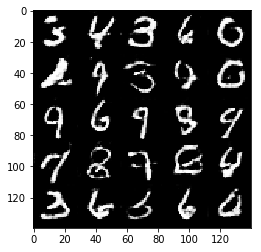


Epoch 2/2 and iteration 4200 The discriminator Loss is 1.428... The generator Loss is 0.468

Epoch 2/2 and iteration 4210 The discriminator Loss is 2.252... The generator Loss is 0.251

Epoch 2/2 and iteration 4220 The discriminator Loss is 0.897... The generator Loss is 0.971

Epoch 2/2 and iteration 4230 The discriminator Loss is 0.984... The generator Loss is 0.928

Epoch 2/2 and iteration 4240 The discriminator Loss is 1.087... The generator Loss is 0.763

Epoch 2/2 and iteration 4250 The discriminator Loss is 0.807... The generator Loss is 1.641

Epoch 2/2 and iteration 4260 The discriminator Loss is 0.994... The generator Loss is 0.979

Epoch 2/2 and iteration 4270 The discriminator Loss is 1.203... The generator Loss is 0.789

Epoch 2/2 and iteration 4280 The discriminator Loss is 1.462... The generator Loss is 0.564

Epoch 2/2 and iteration 4290 The discriminator Loss is 1.268... The generator Loss is 0.567


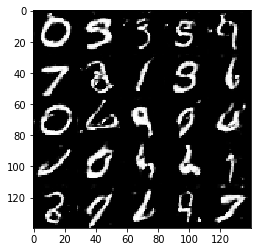


Epoch 2/2 and iteration 4300 The discriminator Loss is 1.118... The generator Loss is 0.698

Epoch 2/2 and iteration 4310 The discriminator Loss is 1.356... The generator Loss is 0.600

Epoch 2/2 and iteration 4320 The discriminator Loss is 0.905... The generator Loss is 0.965

Epoch 2/2 and iteration 4330 The discriminator Loss is 1.086... The generator Loss is 0.904

Epoch 2/2 and iteration 4340 The discriminator Loss is 1.507... The generator Loss is 0.448

Epoch 2/2 and iteration 4350 The discriminator Loss is 1.371... The generator Loss is 0.571

Epoch 2/2 and iteration 4360 The discriminator Loss is 1.787... The generator Loss is 0.377

Epoch 2/2 and iteration 4370 The discriminator Loss is 1.367... The generator Loss is 0.679

Epoch 2/2 and iteration 4380 The discriminator Loss is 0.956... The generator Loss is 1.045

Epoch 2/2 and iteration 4390 The discriminator Loss is 1.050... The generator Loss is 0.853


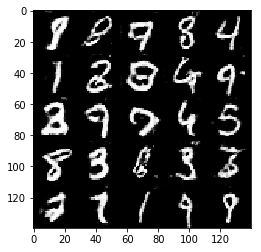


Epoch 2/2 and iteration 4400 The discriminator Loss is 2.218... The generator Loss is 0.309

Epoch 2/2 and iteration 4410 The discriminator Loss is 0.918... The generator Loss is 0.982

Epoch 2/2 and iteration 4420 The discriminator Loss is 1.695... The generator Loss is 0.425

Epoch 2/2 and iteration 4430 The discriminator Loss is 0.917... The generator Loss is 0.924

Epoch 2/2 and iteration 4440 The discriminator Loss is 1.078... The generator Loss is 0.806

Epoch 2/2 and iteration 4450 The discriminator Loss is 0.838... The generator Loss is 1.057

Epoch 2/2 and iteration 4460 The discriminator Loss is 1.319... The generator Loss is 0.580

Epoch 2/2 and iteration 4470 The discriminator Loss is 1.028... The generator Loss is 0.867

Epoch 2/2 and iteration 4480 The discriminator Loss is 1.485... The generator Loss is 0.461

Epoch 2/2 and iteration 4490 The discriminator Loss is 1.424... The generator Loss is 0.521


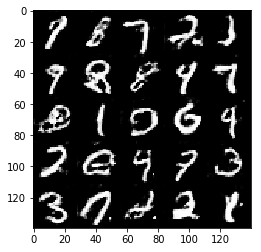


Epoch 2/2 and iteration 4500 The discriminator Loss is 1.424... The generator Loss is 0.529

Epoch 2/2 and iteration 4510 The discriminator Loss is 1.442... The generator Loss is 0.491

Epoch 2/2 and iteration 4520 The discriminator Loss is 2.215... The generator Loss is 0.407

Epoch 2/2 and iteration 4530 The discriminator Loss is 2.022... The generator Loss is 0.247

Epoch 2/2 and iteration 4540 The discriminator Loss is 1.332... The generator Loss is 0.521

Epoch 2/2 and iteration 4550 The discriminator Loss is 1.230... The generator Loss is 0.804

Epoch 2/2 and iteration 4560 The discriminator Loss is 0.741... The generator Loss is 1.246

Epoch 2/2 and iteration 4570 The discriminator Loss is 1.969... The generator Loss is 0.285

Epoch 2/2 and iteration 4580 The discriminator Loss is 1.030... The generator Loss is 0.893

Epoch 2/2 and iteration 4590 The discriminator Loss is 1.264... The generator Loss is 0.556


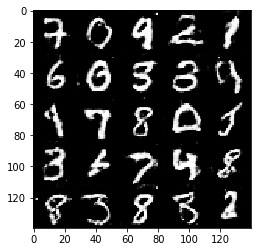


Epoch 2/2 and iteration 4600 The discriminator Loss is 1.179... The generator Loss is 0.806

Epoch 2/2 and iteration 4610 The discriminator Loss is 1.339... The generator Loss is 0.557

Epoch 2/2 and iteration 4620 The discriminator Loss is 1.735... The generator Loss is 0.326

Epoch 2/2 and iteration 4630 The discriminator Loss is 1.883... The generator Loss is 0.309

Epoch 2/2 and iteration 4640 The discriminator Loss is 1.653... The generator Loss is 0.372

Epoch 2/2 and iteration 4650 The discriminator Loss is 0.781... The generator Loss is 1.605

Epoch 2/2 and iteration 4660 The discriminator Loss is 1.731... The generator Loss is 0.429

Epoch 2/2 and iteration 4670 The discriminator Loss is 2.891... The generator Loss is 0.161

Epoch 2/2 and iteration 4680 The discriminator Loss is 0.899... The generator Loss is 1.188

Epoch 2/2 and iteration 4690 The discriminator Loss is 1.595... The generator Loss is 0.413


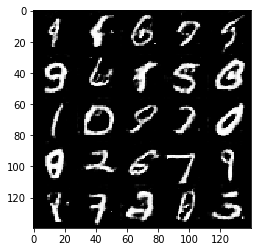


Epoch 2/2 and iteration 4700 The discriminator Loss is 1.608... The generator Loss is 0.463

Epoch 2/2 and iteration 4710 The discriminator Loss is 1.041... The generator Loss is 1.090

Epoch 2/2 and iteration 4720 The discriminator Loss is 1.751... The generator Loss is 0.587

Epoch 2/2 and iteration 4730 The discriminator Loss is 1.354... The generator Loss is 0.583

Epoch 2/2 and iteration 4740 The discriminator Loss is 1.656... The generator Loss is 0.486

Epoch 2/2 and iteration 4750 The discriminator Loss is 1.197... The generator Loss is 0.717

Epoch 2/2 and iteration 4760 The discriminator Loss is 1.436... The generator Loss is 0.458

Epoch 2/2 and iteration 4770 The discriminator Loss is 1.096... The generator Loss is 0.947

Epoch 2/2 and iteration 4780 The discriminator Loss is 1.598... The generator Loss is 0.425

Epoch 2/2 and iteration 4790 The discriminator Loss is 1.222... The generator Loss is 0.780


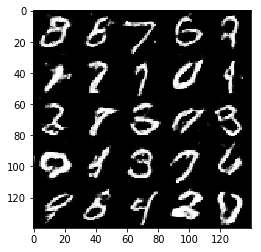


Epoch 2/2 and iteration 4800 The discriminator Loss is 1.770... The generator Loss is 0.403

Epoch 2/2 and iteration 4810 The discriminator Loss is 1.285... The generator Loss is 0.589

Epoch 2/2 and iteration 4820 The discriminator Loss is 1.314... The generator Loss is 0.707

Epoch 2/2 and iteration 4830 The discriminator Loss is 0.934... The generator Loss is 0.948

Epoch 2/2 and iteration 4840 The discriminator Loss is 1.155... The generator Loss is 0.780

Epoch 2/2 and iteration 4850 The discriminator Loss is 2.024... The generator Loss is 0.307

Epoch 2/2 and iteration 4860 The discriminator Loss is 0.747... The generator Loss is 1.648

Epoch 2/2 and iteration 4870 The discriminator Loss is 0.896... The generator Loss is 1.054

Epoch 2/2 and iteration 4880 The discriminator Loss is 1.417... The generator Loss is 0.564

Epoch 2/2 and iteration 4890 The discriminator Loss is 0.789... The generator Loss is 1.240


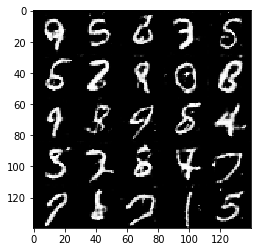


Epoch 2/2 and iteration 4900 The discriminator Loss is 1.175... The generator Loss is 0.651

Epoch 2/2 and iteration 4910 The discriminator Loss is 0.704... The generator Loss is 1.402

Epoch 2/2 and iteration 4920 The discriminator Loss is 0.830... The generator Loss is 1.289

Epoch 2/2 and iteration 4930 The discriminator Loss is 1.028... The generator Loss is 1.054

Epoch 2/2 and iteration 4940 The discriminator Loss is 1.423... The generator Loss is 0.651

Epoch 2/2 and iteration 4950 The discriminator Loss is 1.146... The generator Loss is 0.710

Epoch 2/2 and iteration 4960 The discriminator Loss is 0.845... The generator Loss is 1.158

Epoch 2/2 and iteration 4970 The discriminator Loss is 0.881... The generator Loss is 1.287

Epoch 2/2 and iteration 4980 The discriminator Loss is 0.964... The generator Loss is 1.052

Epoch 2/2 and iteration 4990 The discriminator Loss is 1.935... The generator Loss is 0.298


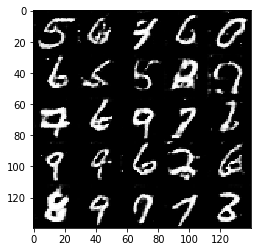


Epoch 2/2 and iteration 5000 The discriminator Loss is 1.665... The generator Loss is 0.443

Epoch 2/2 and iteration 5010 The discriminator Loss is 0.900... The generator Loss is 1.020

Epoch 2/2 and iteration 5020 The discriminator Loss is 0.872... The generator Loss is 1.218

Epoch 2/2 and iteration 5030 The discriminator Loss is 1.195... The generator Loss is 0.626

Epoch 2/2 and iteration 5040 The discriminator Loss is 2.243... The generator Loss is 0.222

Epoch 2/2 and iteration 5050 The discriminator Loss is 1.110... The generator Loss is 0.784

Epoch 2/2 and iteration 5060 The discriminator Loss is 1.627... The generator Loss is 0.385

Epoch 2/2 and iteration 5070 The discriminator Loss is 0.969... The generator Loss is 1.959

Epoch 2/2 and iteration 5080 The discriminator Loss is 0.827... The generator Loss is 1.134

Epoch 2/2 and iteration 5090 The discriminator Loss is 1.028... The generator Loss is 0.781


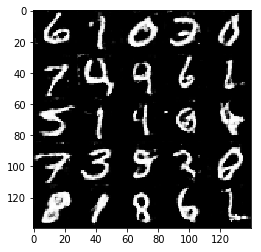


Epoch 2/2 and iteration 5100 The discriminator Loss is 2.144... The generator Loss is 0.267

Epoch 2/2 and iteration 5110 The discriminator Loss is 0.996... The generator Loss is 0.993

Epoch 2/2 and iteration 5120 The discriminator Loss is 0.738... The generator Loss is 1.345

Epoch 2/2 and iteration 5130 The discriminator Loss is 1.044... The generator Loss is 0.762

Epoch 2/2 and iteration 5140 The discriminator Loss is 1.190... The generator Loss is 0.649

Epoch 2/2 and iteration 5150 The discriminator Loss is 1.161... The generator Loss is 0.890

Epoch 2/2 and iteration 5160 The discriminator Loss is 0.964... The generator Loss is 0.972

Epoch 2/2 and iteration 5170 The discriminator Loss is 1.770... The generator Loss is 0.405

Epoch 2/2 and iteration 5180 The discriminator Loss is 1.784... The generator Loss is 0.353

Epoch 2/2 and iteration 5190 The discriminator Loss is 0.882... The generator Loss is 1.007


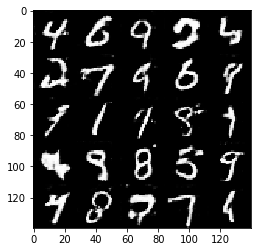


Epoch 2/2 and iteration 5200 The discriminator Loss is 1.497... The generator Loss is 0.487

Epoch 2/2 and iteration 5210 The discriminator Loss is 1.192... The generator Loss is 0.623

Epoch 2/2 and iteration 5220 The discriminator Loss is 0.564... The generator Loss is 1.886

Epoch 2/2 and iteration 5230 The discriminator Loss is 1.012... The generator Loss is 0.868

Epoch 2/2 and iteration 5240 The discriminator Loss is 0.463... The generator Loss is 3.076

Epoch 2/2 and iteration 5250 The discriminator Loss is 0.975... The generator Loss is 0.941

Epoch 2/2 and iteration 5260 The discriminator Loss is 1.831... The generator Loss is 0.442

Epoch 2/2 and iteration 5270 The discriminator Loss is 1.740... The generator Loss is 0.351

Epoch 2/2 and iteration 5280 The discriminator Loss is 1.478... The generator Loss is 0.522

Epoch 2/2 and iteration 5290 The discriminator Loss is 1.151... The generator Loss is 0.953


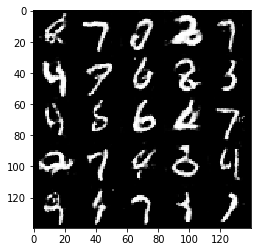


Epoch 2/2 and iteration 5300 The discriminator Loss is 0.918... The generator Loss is 0.930

Epoch 2/2 and iteration 5310 The discriminator Loss is 2.654... The generator Loss is 0.177

Epoch 2/2 and iteration 5320 The discriminator Loss is 3.148... The generator Loss is 0.126

Epoch 2/2 and iteration 5330 The discriminator Loss is 1.168... The generator Loss is 0.709

Epoch 2/2 and iteration 5340 The discriminator Loss is 1.114... The generator Loss is 1.338

Epoch 2/2 and iteration 5350 The discriminator Loss is 0.751... The generator Loss is 1.394

Epoch 2/2 and iteration 5360 The discriminator Loss is 0.847... The generator Loss is 1.130

Epoch 2/2 and iteration 5370 The discriminator Loss is 1.377... The generator Loss is 0.733

Epoch 2/2 and iteration 5380 The discriminator Loss is 1.731... The generator Loss is 0.405

Epoch 2/2 and iteration 5390 The discriminator Loss is 1.568... The generator Loss is 0.485


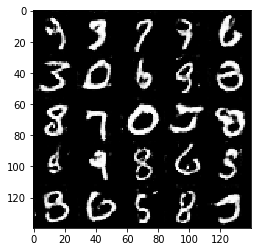


Epoch 2/2 and iteration 5400 The discriminator Loss is 1.054... The generator Loss is 0.836

Epoch 2/2 and iteration 5410 The discriminator Loss is 2.021... The generator Loss is 0.327

Epoch 2/2 and iteration 5420 The discriminator Loss is 0.995... The generator Loss is 1.151

Epoch 2/2 and iteration 5430 The discriminator Loss is 0.952... The generator Loss is 0.894

Epoch 2/2 and iteration 5440 The discriminator Loss is 0.958... The generator Loss is 0.946

Epoch 2/2 and iteration 5450 The discriminator Loss is 1.744... The generator Loss is 0.413

Epoch 2/2 and iteration 5460 The discriminator Loss is 1.300... The generator Loss is 0.632

Epoch 2/2 and iteration 5470 The discriminator Loss is 3.115... The generator Loss is 0.163

Epoch 2/2 and iteration 5480 The discriminator Loss is 1.142... The generator Loss is 0.718

Epoch 2/2 and iteration 5490 The discriminator Loss is 2.237... The generator Loss is 0.272


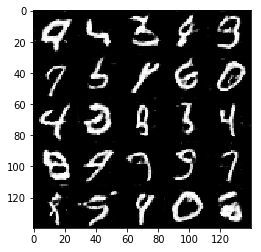


Epoch 2/2 and iteration 5500 The discriminator Loss is 1.395... The generator Loss is 0.513

Epoch 2/2 and iteration 5510 The discriminator Loss is 1.010... The generator Loss is 1.203

Epoch 2/2 and iteration 5520 The discriminator Loss is 2.122... The generator Loss is 0.259

Epoch 2/2 and iteration 5530 The discriminator Loss is 1.325... The generator Loss is 0.572

Epoch 2/2 and iteration 5540 The discriminator Loss is 1.135... The generator Loss is 0.775

Epoch 2/2 and iteration 5550 The discriminator Loss is 0.873... The generator Loss is 1.070

Epoch 2/2 and iteration 5560 The discriminator Loss is 1.256... The generator Loss is 0.635

Epoch 2/2 and iteration 5570 The discriminator Loss is 1.474... The generator Loss is 0.444

Epoch 2/2 and iteration 5580 The discriminator Loss is 1.039... The generator Loss is 0.849

Epoch 2/2 and iteration 5590 The discriminator Loss is 2.790... The generator Loss is 0.175


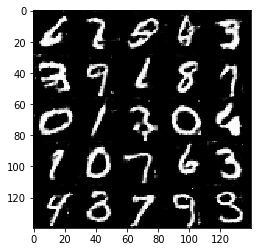


Epoch 2/2 and iteration 5600 The discriminator Loss is 1.678... The generator Loss is 0.467

Epoch 2/2 and iteration 5610 The discriminator Loss is 1.134... The generator Loss is 0.827

Epoch 2/2 and iteration 5620 The discriminator Loss is 0.756... The generator Loss is 1.217

Epoch 2/2 and iteration 5630 The discriminator Loss is 0.943... The generator Loss is 0.917

Epoch 2/2 and iteration 5640 The discriminator Loss is 1.995... The generator Loss is 0.307

Epoch 2/2 and iteration 5650 The discriminator Loss is 1.015... The generator Loss is 1.024

Epoch 2/2 and iteration 5660 The discriminator Loss is 1.318... The generator Loss is 0.576

Epoch 2/2 and iteration 5670 The discriminator Loss is 1.088... The generator Loss is 0.779

Epoch 2/2 and iteration 5680 The discriminator Loss is 1.475... The generator Loss is 0.469

Epoch 2/2 and iteration 5690 The discriminator Loss is 1.463... The generator Loss is 0.441


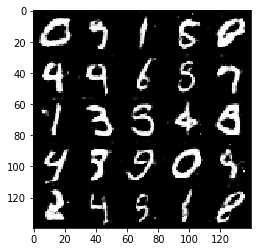


Epoch 2/2 and iteration 5700 The discriminator Loss is 1.150... The generator Loss is 0.806

Epoch 2/2 and iteration 5710 The discriminator Loss is 2.134... The generator Loss is 0.321

Epoch 2/2 and iteration 5720 The discriminator Loss is 2.327... The generator Loss is 0.209

Epoch 2/2 and iteration 5730 The discriminator Loss is 1.099... The generator Loss is 0.858

Epoch 2/2 and iteration 5740 The discriminator Loss is 2.154... The generator Loss is 0.220

Epoch 2/2 and iteration 5750 The discriminator Loss is 1.165... The generator Loss is 0.665

Epoch 2/2 and iteration 5760 The discriminator Loss is 1.325... The generator Loss is 0.577

Epoch 2/2 and iteration 5770 The discriminator Loss is 1.475... The generator Loss is 0.513

Epoch 2/2 and iteration 5780 The discriminator Loss is 1.782... The generator Loss is 0.428

Epoch 2/2 and iteration 5790 The discriminator Loss is 1.731... The generator Loss is 0.339


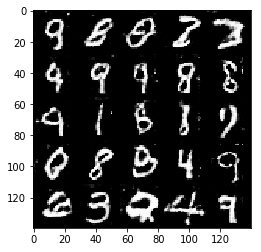


Epoch 2/2 and iteration 5800 The discriminator Loss is 1.516... The generator Loss is 0.433

Epoch 2/2 and iteration 5810 The discriminator Loss is 1.900... The generator Loss is 0.275

Epoch 2/2 and iteration 5820 The discriminator Loss is 1.356... The generator Loss is 0.545

Epoch 2/2 and iteration 5830 The discriminator Loss is 1.591... The generator Loss is 0.417

Epoch 2/2 and iteration 5840 The discriminator Loss is 1.751... The generator Loss is 0.363

Epoch 2/2 and iteration 5850 The discriminator Loss is 1.798... The generator Loss is 0.363

Epoch 2/2 and iteration 5860 The discriminator Loss is 3.574... The generator Loss is 0.090

Epoch 2/2 and iteration 5870 The discriminator Loss is 1.041... The generator Loss is 0.961

Epoch 2/2 and iteration 5880 The discriminator Loss is 1.461... The generator Loss is 0.501

Epoch 2/2 and iteration 5890 The discriminator Loss is 2.616... The generator Loss is 0.160


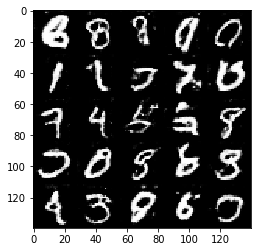


Epoch 2/2 and iteration 5900 The discriminator Loss is 1.237... The generator Loss is 0.699

Epoch 2/2 and iteration 5910 The discriminator Loss is 1.176... The generator Loss is 0.714

Epoch 2/2 and iteration 5920 The discriminator Loss is 1.348... The generator Loss is 0.615

Epoch 2/2 and iteration 5930 The discriminator Loss is 1.288... The generator Loss is 0.675

Epoch 2/2 and iteration 5940 The discriminator Loss is 0.824... The generator Loss is 1.278

Epoch 2/2 and iteration 5950 The discriminator Loss is 1.585... The generator Loss is 0.611

Epoch 2/2 and iteration 5960 The discriminator Loss is 0.950... The generator Loss is 1.088

Epoch 2/2 and iteration 5970 The discriminator Loss is 1.259... The generator Loss is 0.636

Epoch 2/2 and iteration 5980 The discriminator Loss is 2.223... The generator Loss is 0.232

Epoch 2/2 and iteration 5990 The discriminator Loss is 0.662... The generator Loss is 1.522


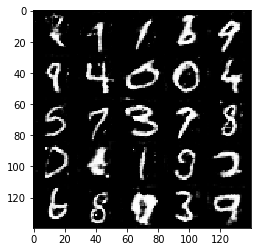


Epoch 2/2 and iteration 6000 The discriminator Loss is 0.826... The generator Loss is 1.089

Epoch 2/2 and iteration 6010 The discriminator Loss is 2.250... The generator Loss is 0.221

Epoch 2/2 and iteration 6020 The discriminator Loss is 2.534... The generator Loss is 0.157

Epoch 2/2 and iteration 6030 The discriminator Loss is 1.376... The generator Loss is 0.608

Epoch 2/2 and iteration 6040 The discriminator Loss is 1.391... The generator Loss is 0.572

Epoch 2/2 and iteration 6050 The discriminator Loss is 1.145... The generator Loss is 0.854

Epoch 2/2 and iteration 6060 The discriminator Loss is 1.337... The generator Loss is 0.537

Epoch 2/2 and iteration 6070 The discriminator Loss is 0.922... The generator Loss is 1.013

Epoch 2/2 and iteration 6080 The discriminator Loss is 1.557... The generator Loss is 0.510

Epoch 2/2 and iteration 6090 The discriminator Loss is 0.751... The generator Loss is 1.336


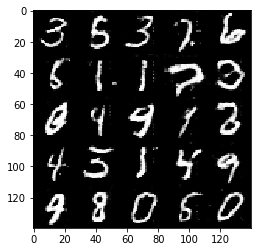


Epoch 2/2 and iteration 6100 The discriminator Loss is 1.351... The generator Loss is 0.549

Epoch 2/2 and iteration 6110 The discriminator Loss is 0.912... The generator Loss is 1.060

Epoch 2/2 and iteration 6120 The discriminator Loss is 1.112... The generator Loss is 0.710

Epoch 2/2 and iteration 6130 The discriminator Loss is 1.171... The generator Loss is 0.806

Epoch 2/2 and iteration 6140 The discriminator Loss is 1.780... The generator Loss is 0.329

Epoch 2/2 and iteration 6150 The discriminator Loss is 1.478... The generator Loss is 0.486

Epoch 2/2 and iteration 6160 The discriminator Loss is 1.739... The generator Loss is 0.392

Epoch 2/2 and iteration 6170 The discriminator Loss is 1.572... The generator Loss is 0.498

Epoch 2/2 and iteration 6180 The discriminator Loss is 1.260... The generator Loss is 0.700

Epoch 2/2 and iteration 6190 The discriminator Loss is 1.600... The generator Loss is 0.427


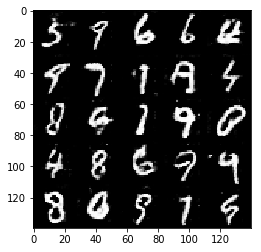


Epoch 2/2 and iteration 6200 The discriminator Loss is 2.750... The generator Loss is 0.148

Epoch 2/2 and iteration 6210 The discriminator Loss is 1.162... The generator Loss is 1.193

Epoch 2/2 and iteration 6220 The discriminator Loss is 1.914... The generator Loss is 0.326

Epoch 2/2 and iteration 6230 The discriminator Loss is 1.972... The generator Loss is 0.276

Epoch 2/2 and iteration 6240 The discriminator Loss is 2.261... The generator Loss is 0.198

Epoch 2/2 and iteration 6250 The discriminator Loss is 1.271... The generator Loss is 0.587

Epoch 2/2 and iteration 6260 The discriminator Loss is 1.260... The generator Loss is 0.612

Epoch 2/2 and iteration 6270 The discriminator Loss is 0.785... The generator Loss is 1.213

Epoch 2/2 and iteration 6280 The discriminator Loss is 1.163... The generator Loss is 0.847

Epoch 2/2 and iteration 6290 The discriminator Loss is 2.509... The generator Loss is 0.183


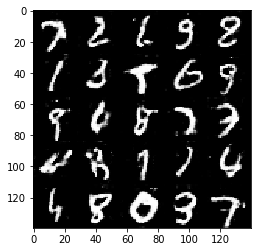


Epoch 2/2 and iteration 6300 The discriminator Loss is 0.549... The generator Loss is 1.960

Epoch 2/2 and iteration 6310 The discriminator Loss is 0.808... The generator Loss is 1.152

Epoch 2/2 and iteration 6320 The discriminator Loss is 1.255... The generator Loss is 0.586

Epoch 2/2 and iteration 6330 The discriminator Loss is 0.632... The generator Loss is 1.585

Epoch 2/2 and iteration 6340 The discriminator Loss is 1.198... The generator Loss is 0.607

Epoch 2/2 and iteration 6350 The discriminator Loss is 1.340... The generator Loss is 0.617

Epoch 2/2 and iteration 6360 The discriminator Loss is 1.478... The generator Loss is 0.496

Epoch 2/2 and iteration 6370 The discriminator Loss is 0.879... The generator Loss is 1.274

Epoch 2/2 and iteration 6380 The discriminator Loss is 1.748... The generator Loss is 0.342

Epoch 2/2 and iteration 6390 The discriminator Loss is 0.906... The generator Loss is 1.054


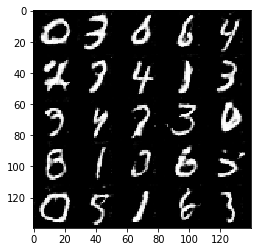


Epoch 2/2 and iteration 6400 The discriminator Loss is 0.780... The generator Loss is 1.794

Epoch 2/2 and iteration 6410 The discriminator Loss is 0.781... The generator Loss is 1.210

Epoch 2/2 and iteration 6420 The discriminator Loss is 0.927... The generator Loss is 0.960

Epoch 2/2 and iteration 6430 The discriminator Loss is 0.912... The generator Loss is 1.007

Epoch 2/2 and iteration 6440 The discriminator Loss is 1.282... The generator Loss is 0.600

Epoch 2/2 and iteration 6450 The discriminator Loss is 1.492... The generator Loss is 0.438

Epoch 2/2 and iteration 6460 The discriminator Loss is 0.921... The generator Loss is 0.947

Epoch 2/2 and iteration 6470 The discriminator Loss is 0.758... The generator Loss is 1.430

Epoch 2/2 and iteration 6480 The discriminator Loss is 1.687... The generator Loss is 0.369

Epoch 2/2 and iteration 6490 The discriminator Loss is 1.118... The generator Loss is 0.964


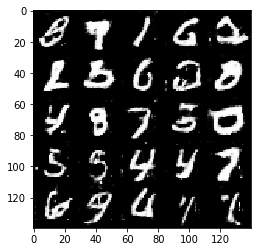


Epoch 2/2 and iteration 6500 The discriminator Loss is 2.732... The generator Loss is 0.126

Epoch 2/2 and iteration 6510 The discriminator Loss is 1.332... The generator Loss is 0.561

Epoch 2/2 and iteration 6520 The discriminator Loss is 1.984... The generator Loss is 0.321

Epoch 2/2 and iteration 6530 The discriminator Loss is 1.237... The generator Loss is 0.623

Epoch 2/2 and iteration 6540 The discriminator Loss is 1.756... The generator Loss is 0.435

Epoch 2/2 and iteration 6550 The discriminator Loss is 1.894... The generator Loss is 0.380

Epoch 2/2 and iteration 6560 The discriminator Loss is 1.699... The generator Loss is 0.355

Epoch 2/2 and iteration 6570 The discriminator Loss is 1.805... The generator Loss is 0.312

Epoch 2/2 and iteration 6580 The discriminator Loss is 0.686... The generator Loss is 2.202

Epoch 2/2 and iteration 6590 The discriminator Loss is 2.835... The generator Loss is 0.133


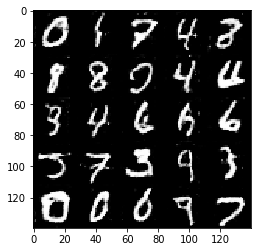


Epoch 2/2 and iteration 6600 The discriminator Loss is 1.162... The generator Loss is 1.008

Epoch 2/2 and iteration 6610 The discriminator Loss is 1.071... The generator Loss is 0.807

Epoch 2/2 and iteration 6620 The discriminator Loss is 1.456... The generator Loss is 0.486

Epoch 2/2 and iteration 6630 The discriminator Loss is 0.958... The generator Loss is 0.957

Epoch 2/2 and iteration 6640 The discriminator Loss is 1.232... The generator Loss is 0.783

Epoch 2/2 and iteration 6650 The discriminator Loss is 1.016... The generator Loss is 0.816

Epoch 2/2 and iteration 6660 The discriminator Loss is 0.694... The generator Loss is 1.487

Epoch 2/2 and iteration 6670 The discriminator Loss is 0.864... The generator Loss is 0.992

Epoch 2/2 and iteration 6680 The discriminator Loss is 0.770... The generator Loss is 1.269

Epoch 2/2 and iteration 6690 The discriminator Loss is 1.225... The generator Loss is 0.618


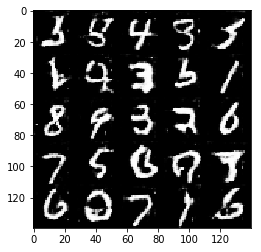


Epoch 2/2 and iteration 6700 The discriminator Loss is 1.684... The generator Loss is 0.399

Epoch 2/2 and iteration 6710 The discriminator Loss is 1.239... The generator Loss is 0.575

Epoch 2/2 and iteration 6720 The discriminator Loss is 1.384... The generator Loss is 0.520

Epoch 2/2 and iteration 6730 The discriminator Loss is 1.537... The generator Loss is 0.418

Epoch 2/2 and iteration 6740 The discriminator Loss is 1.165... The generator Loss is 0.654

Epoch 2/2 and iteration 6750 The discriminator Loss is 1.018... The generator Loss is 0.953

Epoch 2/2 and iteration 6760 The discriminator Loss is 1.530... The generator Loss is 0.533

Epoch 2/2 and iteration 6770 The discriminator Loss is 1.042... The generator Loss is 0.853

Epoch 2/2 and iteration 6780 The discriminator Loss is 0.760... The generator Loss is 1.291

Epoch 2/2 and iteration 6790 The discriminator Loss is 1.372... The generator Loss is 0.565


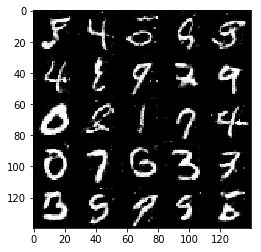


Epoch 2/2 and iteration 6800 The discriminator Loss is 1.175... The generator Loss is 0.685

Epoch 2/2 and iteration 6810 The discriminator Loss is 1.481... The generator Loss is 0.524

Epoch 2/2 and iteration 6820 The discriminator Loss is 1.213... The generator Loss is 0.664

Epoch 2/2 and iteration 6830 The discriminator Loss is 1.195... The generator Loss is 0.696

Epoch 2/2 and iteration 6840 The discriminator Loss is 0.526... The generator Loss is 1.970

Epoch 2/2 and iteration 6850 The discriminator Loss is 1.738... The generator Loss is 0.346

Epoch 2/2 and iteration 6860 The discriminator Loss is 1.592... The generator Loss is 0.453

Epoch 2/2 and iteration 6870 The discriminator Loss is 1.625... The generator Loss is 0.395

Epoch 2/2 and iteration 6880 The discriminator Loss is 0.928... The generator Loss is 0.913

Epoch 2/2 and iteration 6890 The discriminator Loss is 1.100... The generator Loss is 0.758


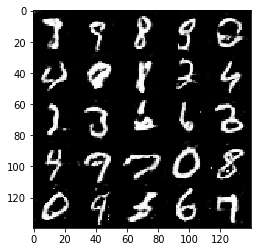


Epoch 2/2 and iteration 6900 The discriminator Loss is 1.201... The generator Loss is 5.541

Epoch 2/2 and iteration 6910 The discriminator Loss is 1.277... The generator Loss is 0.756

Epoch 2/2 and iteration 6920 The discriminator Loss is 1.225... The generator Loss is 0.606

Epoch 2/2 and iteration 6930 The discriminator Loss is 1.503... The generator Loss is 0.524

Epoch 2/2 and iteration 6940 The discriminator Loss is 1.585... The generator Loss is 0.440

Epoch 2/2 and iteration 6950 The discriminator Loss is 1.222... The generator Loss is 0.685

Epoch 2/2 and iteration 6960 The discriminator Loss is 1.325... The generator Loss is 0.608

Epoch 2/2 and iteration 6970 The discriminator Loss is 1.558... The generator Loss is 0.483

Epoch 2/2 and iteration 6980 The discriminator Loss is 0.660... The generator Loss is 2.076

Epoch 2/2 and iteration 6990 The discriminator Loss is 1.361... The generator Loss is 0.570


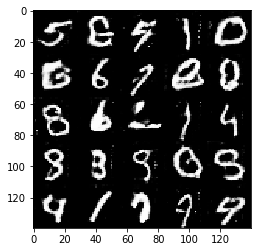


Epoch 2/2 and iteration 7000 The discriminator Loss is 0.854... The generator Loss is 1.133

Epoch 2/2 and iteration 7010 The discriminator Loss is 1.001... The generator Loss is 1.001

Epoch 2/2 and iteration 7020 The discriminator Loss is 1.034... The generator Loss is 0.845

Epoch 2/2 and iteration 7030 The discriminator Loss is 1.025... The generator Loss is 0.975

Epoch 2/2 and iteration 7040 The discriminator Loss is 1.071... The generator Loss is 0.740

Epoch 2/2 and iteration 7050 The discriminator Loss is 1.226... The generator Loss is 0.623

Epoch 2/2 and iteration 7060 The discriminator Loss is 1.221... The generator Loss is 0.676

Epoch 2/2 and iteration 7070 The discriminator Loss is 1.602... The generator Loss is 2.273

Epoch 2/2 and iteration 7080 The discriminator Loss is 1.294... The generator Loss is 0.579

Epoch 2/2 and iteration 7090 The discriminator Loss is 0.870... The generator Loss is 1.041


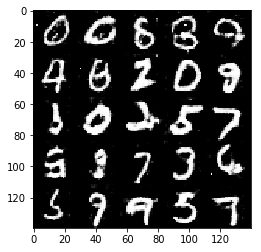


Epoch 2/2 and iteration 7100 The discriminator Loss is 1.439... The generator Loss is 0.547

Epoch 2/2 and iteration 7110 The discriminator Loss is 0.873... The generator Loss is 1.114

Epoch 2/2 and iteration 7120 The discriminator Loss is 1.069... The generator Loss is 0.752

Epoch 2/2 and iteration 7130 The discriminator Loss is 0.722... The generator Loss is 1.269

Epoch 2/2 and iteration 7140 The discriminator Loss is 1.487... The generator Loss is 0.439

Epoch 2/2 and iteration 7150 The discriminator Loss is 0.867... The generator Loss is 1.424

Epoch 2/2 and iteration 7160 The discriminator Loss is 1.708... The generator Loss is 0.356

Epoch 2/2 and iteration 7170 The discriminator Loss is 1.517... The generator Loss is 0.423

Epoch 2/2 and iteration 7180 The discriminator Loss is 1.881... The generator Loss is 0.285

Epoch 2/2 and iteration 7190 The discriminator Loss is 2.315... The generator Loss is 4.951


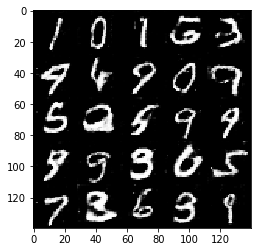


Epoch 2/2 and iteration 7200 The discriminator Loss is 1.636... The generator Loss is 0.570

Epoch 2/2 and iteration 7210 The discriminator Loss is 1.336... The generator Loss is 0.616

Epoch 2/2 and iteration 7220 The discriminator Loss is 1.212... The generator Loss is 2.615

Epoch 2/2 and iteration 7230 The discriminator Loss is 0.710... The generator Loss is 1.328

Epoch 2/2 and iteration 7240 The discriminator Loss is 1.709... The generator Loss is 0.455

Epoch 2/2 and iteration 7250 The discriminator Loss is 1.477... The generator Loss is 0.427

Epoch 2/2 and iteration 7260 The discriminator Loss is 0.752... The generator Loss is 1.157

Epoch 2/2 and iteration 7270 The discriminator Loss is 0.997... The generator Loss is 0.885

Epoch 2/2 and iteration 7280 The discriminator Loss is 1.927... The generator Loss is 0.389

Epoch 2/2 and iteration 7290 The discriminator Loss is 1.121... The generator Loss is 0.770


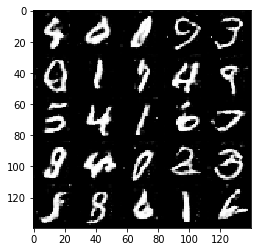


Epoch 2/2 and iteration 7300 The discriminator Loss is 1.261... The generator Loss is 0.588

Epoch 2/2 and iteration 7310 The discriminator Loss is 2.159... The generator Loss is 0.298

Epoch 2/2 and iteration 7320 The discriminator Loss is 1.743... The generator Loss is 0.379

Epoch 2/2 and iteration 7330 The discriminator Loss is 1.631... The generator Loss is 0.400

Epoch 2/2 and iteration 7340 The discriminator Loss is 0.567... The generator Loss is 1.989

Epoch 2/2 and iteration 7350 The discriminator Loss is 1.195... The generator Loss is 0.693

Epoch 2/2 and iteration 7360 The discriminator Loss is 0.737... The generator Loss is 1.239

Epoch 2/2 and iteration 7370 The discriminator Loss is 0.903... The generator Loss is 0.906

Epoch 2/2 and iteration 7380 The discriminator Loss is 1.482... The generator Loss is 0.518

Epoch 2/2 and iteration 7390 The discriminator Loss is 1.349... The generator Loss is 0.567


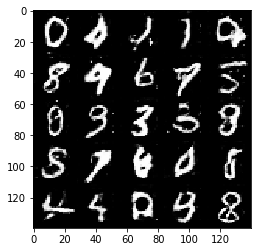


Epoch 2/2 and iteration 7400 The discriminator Loss is 1.276... The generator Loss is 0.682

Epoch 2/2 and iteration 7410 The discriminator Loss is 1.050... The generator Loss is 0.819

Epoch 2/2 and iteration 7420 The discriminator Loss is 2.142... The generator Loss is 0.274

Epoch 2/2 and iteration 7430 The discriminator Loss is 1.120... The generator Loss is 0.742

Epoch 2/2 and iteration 7440 The discriminator Loss is 0.910... The generator Loss is 0.898

Epoch 2/2 and iteration 7450 The discriminator Loss is 1.408... The generator Loss is 0.476

Epoch 2/2 and iteration 7460 The discriminator Loss is 1.348... The generator Loss is 0.494

Epoch 2/2 and iteration 7470 The discriminator Loss is 1.082... The generator Loss is 0.831

Epoch 2/2 and iteration 7480 The discriminator Loss is 1.270... The generator Loss is 0.622

Epoch 2/2 and iteration 7490 The discriminator Loss is 1.717... The generator Loss is 0.344


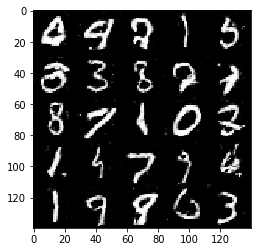


Epoch 2/2 and iteration 7500 The discriminator Loss is 1.088... The generator Loss is 0.893

Epoch 2/2... The discriminator Loss is 1.08829... The generator Loss: 0.89261


In [17]:
batch_size = 16
z_dim = 100
learning_rate = 0.001
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.


Epoch 1/1 and iteration 10 The discriminator Loss is 5.967... The generator Loss is 0.014

Epoch 1/1 and iteration 20 The discriminator Loss is 3.046... The generator Loss is 0.097

Epoch 1/1 and iteration 30 The discriminator Loss is 2.071... The generator Loss is 0.279

Epoch 1/1 and iteration 40 The discriminator Loss is 2.197... The generator Loss is 0.229

Epoch 1/1 and iteration 50 The discriminator Loss is 2.149... The generator Loss is 0.873

Epoch 1/1 and iteration 60 The discriminator Loss is 2.037... The generator Loss is 0.465

Epoch 1/1 and iteration 70 The discriminator Loss is 2.167... The generator Loss is 0.260

Epoch 1/1 and iteration 80 The discriminator Loss is 2.118... The generator Loss is 0.461

Epoch 1/1 and iteration 90 The discriminator Loss is 1.730... The generator Loss is 0.464


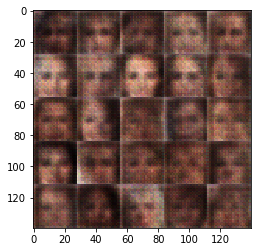


Epoch 1/1 and iteration 100 The discriminator Loss is 1.626... The generator Loss is 0.599

Epoch 1/1 and iteration 110 The discriminator Loss is 1.506... The generator Loss is 0.668

Epoch 1/1 and iteration 120 The discriminator Loss is 1.449... The generator Loss is 0.620

Epoch 1/1 and iteration 130 The discriminator Loss is 1.661... The generator Loss is 0.648

Epoch 1/1 and iteration 140 The discriminator Loss is 1.660... The generator Loss is 0.470

Epoch 1/1 and iteration 150 The discriminator Loss is 1.343... The generator Loss is 0.922

Epoch 1/1 and iteration 160 The discriminator Loss is 1.559... The generator Loss is 0.511

Epoch 1/1 and iteration 170 The discriminator Loss is 1.657... The generator Loss is 0.460

Epoch 1/1 and iteration 180 The discriminator Loss is 1.512... The generator Loss is 0.625

Epoch 1/1 and iteration 190 The discriminator Loss is 1.671... The generator Loss is 0.482


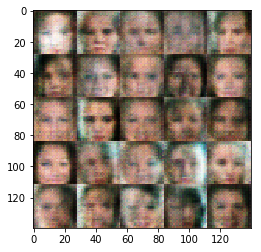


Epoch 1/1 and iteration 200 The discriminator Loss is 1.477... The generator Loss is 0.541

Epoch 1/1 and iteration 210 The discriminator Loss is 1.587... The generator Loss is 0.880

Epoch 1/1 and iteration 220 The discriminator Loss is 1.585... The generator Loss is 0.834

Epoch 1/1 and iteration 230 The discriminator Loss is 1.475... The generator Loss is 0.738

Epoch 1/1 and iteration 240 The discriminator Loss is 1.507... The generator Loss is 0.706

Epoch 1/1 and iteration 250 The discriminator Loss is 1.474... The generator Loss is 0.660

Epoch 1/1 and iteration 260 The discriminator Loss is 1.487... The generator Loss is 0.629

Epoch 1/1 and iteration 270 The discriminator Loss is 1.808... The generator Loss is 0.646

Epoch 1/1 and iteration 280 The discriminator Loss is 1.558... The generator Loss is 0.759

Epoch 1/1 and iteration 290 The discriminator Loss is 1.514... The generator Loss is 0.529


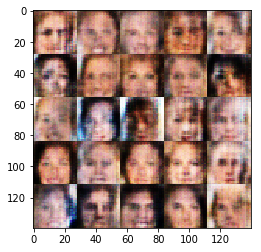


Epoch 1/1 and iteration 300 The discriminator Loss is 1.581... The generator Loss is 0.606

Epoch 1/1 and iteration 310 The discriminator Loss is 1.722... The generator Loss is 0.588

Epoch 1/1 and iteration 320 The discriminator Loss is 1.489... The generator Loss is 0.571

Epoch 1/1 and iteration 330 The discriminator Loss is 1.384... The generator Loss is 0.877

Epoch 1/1 and iteration 340 The discriminator Loss is 1.787... The generator Loss is 0.420

Epoch 1/1 and iteration 350 The discriminator Loss is 1.432... The generator Loss is 0.661

Epoch 1/1 and iteration 360 The discriminator Loss is 1.546... The generator Loss is 0.583

Epoch 1/1 and iteration 370 The discriminator Loss is 1.656... The generator Loss is 0.619

Epoch 1/1 and iteration 380 The discriminator Loss is 1.516... The generator Loss is 0.592

Epoch 1/1 and iteration 390 The discriminator Loss is 1.471... The generator Loss is 0.568


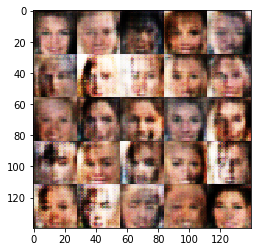


Epoch 1/1 and iteration 400 The discriminator Loss is 1.423... The generator Loss is 0.620

Epoch 1/1 and iteration 410 The discriminator Loss is 1.527... The generator Loss is 0.732

Epoch 1/1 and iteration 420 The discriminator Loss is 1.439... The generator Loss is 0.709

Epoch 1/1 and iteration 430 The discriminator Loss is 1.484... The generator Loss is 0.646

Epoch 1/1 and iteration 440 The discriminator Loss is 1.543... The generator Loss is 0.757

Epoch 1/1 and iteration 450 The discriminator Loss is 1.432... The generator Loss is 0.757

Epoch 1/1 and iteration 460 The discriminator Loss is 1.532... The generator Loss is 0.614

Epoch 1/1 and iteration 470 The discriminator Loss is 1.598... The generator Loss is 0.505

Epoch 1/1 and iteration 480 The discriminator Loss is 1.351... The generator Loss is 0.793

Epoch 1/1 and iteration 490 The discriminator Loss is 1.573... The generator Loss is 0.754


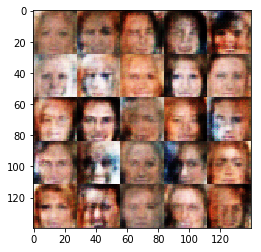


Epoch 1/1 and iteration 500 The discriminator Loss is 1.442... The generator Loss is 0.706

Epoch 1/1 and iteration 510 The discriminator Loss is 1.535... The generator Loss is 0.658

Epoch 1/1 and iteration 520 The discriminator Loss is 1.464... The generator Loss is 0.498

Epoch 1/1 and iteration 530 The discriminator Loss is 1.564... The generator Loss is 0.458

Epoch 1/1 and iteration 540 The discriminator Loss is 1.338... The generator Loss is 0.734

Epoch 1/1 and iteration 550 The discriminator Loss is 1.687... The generator Loss is 0.689

Epoch 1/1 and iteration 560 The discriminator Loss is 1.388... The generator Loss is 0.643

Epoch 1/1 and iteration 570 The discriminator Loss is 1.505... The generator Loss is 0.706

Epoch 1/1 and iteration 580 The discriminator Loss is 1.414... The generator Loss is 0.716

Epoch 1/1 and iteration 590 The discriminator Loss is 1.461... The generator Loss is 0.763


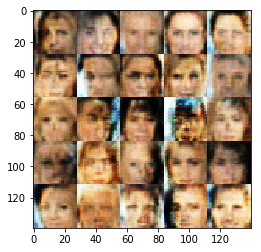


Epoch 1/1 and iteration 600 The discriminator Loss is 1.469... The generator Loss is 0.839

Epoch 1/1 and iteration 610 The discriminator Loss is 1.497... The generator Loss is 0.571

Epoch 1/1 and iteration 620 The discriminator Loss is 1.425... The generator Loss is 0.726

Epoch 1/1 and iteration 630 The discriminator Loss is 1.615... The generator Loss is 0.606

Epoch 1/1 and iteration 640 The discriminator Loss is 1.510... The generator Loss is 0.734

Epoch 1/1 and iteration 650 The discriminator Loss is 1.439... The generator Loss is 0.594

Epoch 1/1 and iteration 660 The discriminator Loss is 1.512... The generator Loss is 0.555

Epoch 1/1 and iteration 670 The discriminator Loss is 1.403... The generator Loss is 0.622

Epoch 1/1 and iteration 680 The discriminator Loss is 1.409... The generator Loss is 0.756

Epoch 1/1 and iteration 690 The discriminator Loss is 1.527... The generator Loss is 0.613


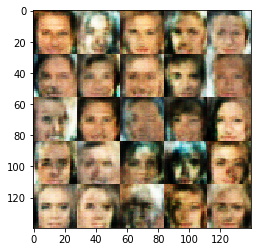


Epoch 1/1 and iteration 700 The discriminator Loss is 1.526... The generator Loss is 0.571

Epoch 1/1 and iteration 710 The discriminator Loss is 1.550... The generator Loss is 0.601

Epoch 1/1 and iteration 720 The discriminator Loss is 1.280... The generator Loss is 0.959

Epoch 1/1 and iteration 730 The discriminator Loss is 1.481... The generator Loss is 0.595

Epoch 1/1 and iteration 740 The discriminator Loss is 1.326... The generator Loss is 0.857

Epoch 1/1 and iteration 750 The discriminator Loss is 1.462... The generator Loss is 0.811

Epoch 1/1 and iteration 760 The discriminator Loss is 1.642... The generator Loss is 0.612

Epoch 1/1 and iteration 770 The discriminator Loss is 1.509... The generator Loss is 0.652

Epoch 1/1 and iteration 780 The discriminator Loss is 1.375... The generator Loss is 0.654

Epoch 1/1 and iteration 790 The discriminator Loss is 1.556... The generator Loss is 0.744


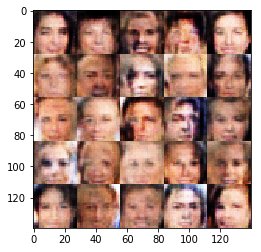


Epoch 1/1 and iteration 800 The discriminator Loss is 1.432... The generator Loss is 0.606

Epoch 1/1 and iteration 810 The discriminator Loss is 1.571... The generator Loss is 0.474

Epoch 1/1 and iteration 820 The discriminator Loss is 1.652... The generator Loss is 0.364

Epoch 1/1 and iteration 830 The discriminator Loss is 1.567... The generator Loss is 0.565

Epoch 1/1 and iteration 840 The discriminator Loss is 1.530... The generator Loss is 0.737

Epoch 1/1 and iteration 850 The discriminator Loss is 1.471... The generator Loss is 0.806

Epoch 1/1 and iteration 860 The discriminator Loss is 1.599... The generator Loss is 0.688

Epoch 1/1 and iteration 870 The discriminator Loss is 1.496... The generator Loss is 0.686

Epoch 1/1 and iteration 880 The discriminator Loss is 1.446... The generator Loss is 0.718

Epoch 1/1 and iteration 890 The discriminator Loss is 1.359... The generator Loss is 0.875


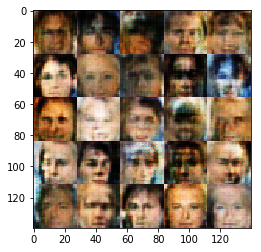


Epoch 1/1 and iteration 900 The discriminator Loss is 1.550... The generator Loss is 0.758

Epoch 1/1 and iteration 910 The discriminator Loss is 1.504... The generator Loss is 0.522

Epoch 1/1 and iteration 920 The discriminator Loss is 1.483... The generator Loss is 0.762

Epoch 1/1 and iteration 930 The discriminator Loss is 1.618... The generator Loss is 0.762

Epoch 1/1 and iteration 940 The discriminator Loss is 1.548... The generator Loss is 0.733

Epoch 1/1 and iteration 950 The discriminator Loss is 1.489... The generator Loss is 0.717

Epoch 1/1 and iteration 960 The discriminator Loss is 1.444... The generator Loss is 0.728

Epoch 1/1 and iteration 970 The discriminator Loss is 1.437... The generator Loss is 0.613

Epoch 1/1 and iteration 980 The discriminator Loss is 1.448... The generator Loss is 0.647

Epoch 1/1 and iteration 990 The discriminator Loss is 1.392... The generator Loss is 0.854


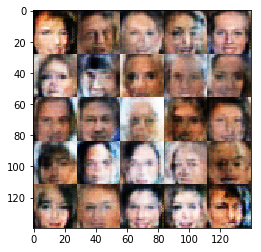


Epoch 1/1 and iteration 1000 The discriminator Loss is 1.488... The generator Loss is 0.792

Epoch 1/1 and iteration 1010 The discriminator Loss is 1.577... The generator Loss is 0.533

Epoch 1/1 and iteration 1020 The discriminator Loss is 1.403... The generator Loss is 0.989

Epoch 1/1 and iteration 1030 The discriminator Loss is 1.467... The generator Loss is 0.703

Epoch 1/1 and iteration 1040 The discriminator Loss is 1.507... The generator Loss is 0.833

Epoch 1/1 and iteration 1050 The discriminator Loss is 1.503... The generator Loss is 0.640

Epoch 1/1 and iteration 1060 The discriminator Loss is 1.460... The generator Loss is 0.720

Epoch 1/1 and iteration 1070 The discriminator Loss is 1.452... The generator Loss is 0.613

Epoch 1/1 and iteration 1080 The discriminator Loss is 1.562... The generator Loss is 0.567

Epoch 1/1 and iteration 1090 The discriminator Loss is 1.650... The generator Loss is 0.467


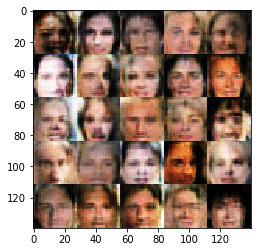


Epoch 1/1 and iteration 1100 The discriminator Loss is 1.504... The generator Loss is 0.627

Epoch 1/1 and iteration 1110 The discriminator Loss is 1.418... The generator Loss is 0.773

Epoch 1/1 and iteration 1120 The discriminator Loss is 1.383... The generator Loss is 0.624

Epoch 1/1 and iteration 1130 The discriminator Loss is 1.452... The generator Loss is 0.620

Epoch 1/1 and iteration 1140 The discriminator Loss is 1.598... The generator Loss is 0.542

Epoch 1/1 and iteration 1150 The discriminator Loss is 1.470... The generator Loss is 0.657

Epoch 1/1 and iteration 1160 The discriminator Loss is 1.572... The generator Loss is 0.547

Epoch 1/1 and iteration 1170 The discriminator Loss is 1.471... The generator Loss is 0.656

Epoch 1/1 and iteration 1180 The discriminator Loss is 1.488... The generator Loss is 0.652

Epoch 1/1 and iteration 1190 The discriminator Loss is 1.474... The generator Loss is 0.646


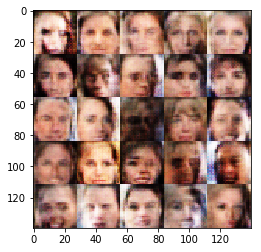


Epoch 1/1 and iteration 1200 The discriminator Loss is 1.518... The generator Loss is 0.571

Epoch 1/1 and iteration 1210 The discriminator Loss is 1.557... The generator Loss is 0.738

Epoch 1/1 and iteration 1220 The discriminator Loss is 1.530... The generator Loss is 0.617

Epoch 1/1 and iteration 1230 The discriminator Loss is 1.553... The generator Loss is 0.556

Epoch 1/1 and iteration 1240 The discriminator Loss is 1.704... The generator Loss is 0.362

Epoch 1/1 and iteration 1250 The discriminator Loss is 1.572... The generator Loss is 0.538

Epoch 1/1 and iteration 1260 The discriminator Loss is 1.452... The generator Loss is 0.649

Epoch 1/1 and iteration 1270 The discriminator Loss is 1.493... The generator Loss is 0.603

Epoch 1/1 and iteration 1280 The discriminator Loss is 1.441... The generator Loss is 0.590

Epoch 1/1 and iteration 1290 The discriminator Loss is 1.376... The generator Loss is 0.611


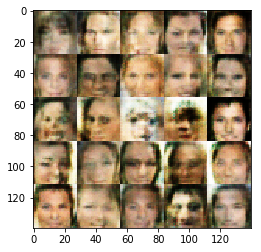


Epoch 1/1 and iteration 1300 The discriminator Loss is 1.497... The generator Loss is 0.619

Epoch 1/1 and iteration 1310 The discriminator Loss is 1.554... The generator Loss is 0.540

Epoch 1/1 and iteration 1320 The discriminator Loss is 1.605... The generator Loss is 0.626

Epoch 1/1 and iteration 1330 The discriminator Loss is 1.417... The generator Loss is 0.730

Epoch 1/1 and iteration 1340 The discriminator Loss is 1.466... The generator Loss is 0.888

Epoch 1/1 and iteration 1350 The discriminator Loss is 1.464... The generator Loss is 0.742

Epoch 1/1 and iteration 1360 The discriminator Loss is 1.468... The generator Loss is 0.561

Epoch 1/1 and iteration 1370 The discriminator Loss is 1.375... The generator Loss is 0.795

Epoch 1/1 and iteration 1380 The discriminator Loss is 1.504... The generator Loss is 0.633

Epoch 1/1 and iteration 1390 The discriminator Loss is 1.487... The generator Loss is 0.612


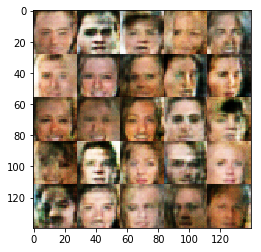


Epoch 1/1 and iteration 1400 The discriminator Loss is 1.525... The generator Loss is 0.598

Epoch 1/1 and iteration 1410 The discriminator Loss is 1.450... The generator Loss is 0.783

Epoch 1/1 and iteration 1420 The discriminator Loss is 1.472... The generator Loss is 0.678

Epoch 1/1 and iteration 1430 The discriminator Loss is 1.508... The generator Loss is 0.627

Epoch 1/1 and iteration 1440 The discriminator Loss is 1.355... The generator Loss is 0.824

Epoch 1/1 and iteration 1450 The discriminator Loss is 1.398... The generator Loss is 0.772

Epoch 1/1 and iteration 1460 The discriminator Loss is 1.490... The generator Loss is 0.576

Epoch 1/1 and iteration 1470 The discriminator Loss is 1.597... The generator Loss is 0.615

Epoch 1/1 and iteration 1480 The discriminator Loss is 1.573... The generator Loss is 0.536

Epoch 1/1 and iteration 1490 The discriminator Loss is 1.436... The generator Loss is 0.783


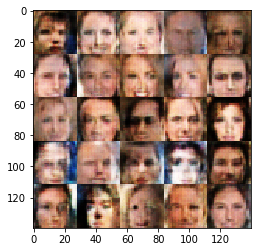


Epoch 1/1 and iteration 1500 The discriminator Loss is 1.545... The generator Loss is 0.964

Epoch 1/1 and iteration 1510 The discriminator Loss is 1.467... The generator Loss is 0.601

Epoch 1/1 and iteration 1520 The discriminator Loss is 1.445... The generator Loss is 0.686

Epoch 1/1 and iteration 1530 The discriminator Loss is 1.460... The generator Loss is 0.700

Epoch 1/1 and iteration 1540 The discriminator Loss is 1.830... The generator Loss is 0.308

Epoch 1/1 and iteration 1550 The discriminator Loss is 1.583... The generator Loss is 0.727

Epoch 1/1 and iteration 1560 The discriminator Loss is 1.414... The generator Loss is 0.795

Epoch 1/1 and iteration 1570 The discriminator Loss is 1.574... The generator Loss is 0.768

Epoch 1/1 and iteration 1580 The discriminator Loss is 1.501... The generator Loss is 0.624

Epoch 1/1 and iteration 1590 The discriminator Loss is 1.595... The generator Loss is 0.578


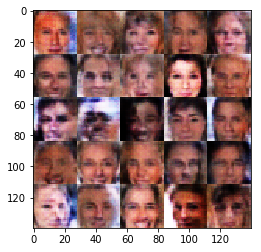


Epoch 1/1 and iteration 1600 The discriminator Loss is 1.419... The generator Loss is 0.612

Epoch 1/1 and iteration 1610 The discriminator Loss is 1.457... The generator Loss is 0.582

Epoch 1/1 and iteration 1620 The discriminator Loss is 1.485... The generator Loss is 0.611

Epoch 1/1 and iteration 1630 The discriminator Loss is 1.401... The generator Loss is 0.695

Epoch 1/1 and iteration 1640 The discriminator Loss is 1.449... The generator Loss is 0.622

Epoch 1/1 and iteration 1650 The discriminator Loss is 1.446... The generator Loss is 0.630

Epoch 1/1 and iteration 1660 The discriminator Loss is 1.395... The generator Loss is 0.739

Epoch 1/1 and iteration 1670 The discriminator Loss is 1.504... The generator Loss is 0.726

Epoch 1/1 and iteration 1680 The discriminator Loss is 1.514... The generator Loss is 0.689

Epoch 1/1 and iteration 1690 The discriminator Loss is 1.517... The generator Loss is 0.734


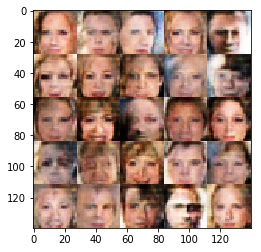


Epoch 1/1 and iteration 1700 The discriminator Loss is 1.551... The generator Loss is 0.535

Epoch 1/1 and iteration 1710 The discriminator Loss is 1.447... The generator Loss is 0.555

Epoch 1/1 and iteration 1720 The discriminator Loss is 1.579... The generator Loss is 0.432

Epoch 1/1 and iteration 1730 The discriminator Loss is 1.575... The generator Loss is 0.643

Epoch 1/1 and iteration 1740 The discriminator Loss is 1.394... The generator Loss is 0.670

Epoch 1/1 and iteration 1750 The discriminator Loss is 1.587... The generator Loss is 0.650

Epoch 1/1 and iteration 1760 The discriminator Loss is 1.572... The generator Loss is 0.714

Epoch 1/1 and iteration 1770 The discriminator Loss is 1.515... The generator Loss is 0.572

Epoch 1/1 and iteration 1780 The discriminator Loss is 1.510... The generator Loss is 0.549

Epoch 1/1 and iteration 1790 The discriminator Loss is 1.490... The generator Loss is 0.603


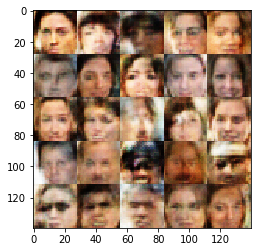


Epoch 1/1 and iteration 1800 The discriminator Loss is 1.591... The generator Loss is 0.601

Epoch 1/1 and iteration 1810 The discriminator Loss is 1.532... The generator Loss is 0.612

Epoch 1/1 and iteration 1820 The discriminator Loss is 1.413... The generator Loss is 0.774

Epoch 1/1 and iteration 1830 The discriminator Loss is 1.562... The generator Loss is 0.548

Epoch 1/1 and iteration 1840 The discriminator Loss is 1.581... The generator Loss is 0.506

Epoch 1/1 and iteration 1850 The discriminator Loss is 1.425... The generator Loss is 0.620

Epoch 1/1 and iteration 1860 The discriminator Loss is 1.526... The generator Loss is 0.568

Epoch 1/1 and iteration 1870 The discriminator Loss is 1.537... The generator Loss is 0.607

Epoch 1/1 and iteration 1880 The discriminator Loss is 1.462... The generator Loss is 0.779

Epoch 1/1 and iteration 1890 The discriminator Loss is 1.564... The generator Loss is 0.471


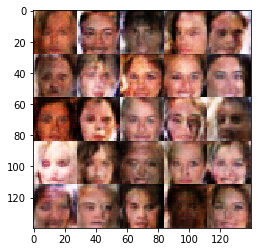


Epoch 1/1 and iteration 1900 The discriminator Loss is 1.574... The generator Loss is 0.550

Epoch 1/1 and iteration 1910 The discriminator Loss is 1.512... The generator Loss is 0.492

Epoch 1/1 and iteration 1920 The discriminator Loss is 1.425... The generator Loss is 0.702

Epoch 1/1 and iteration 1930 The discriminator Loss is 1.488... The generator Loss is 0.640

Epoch 1/1 and iteration 1940 The discriminator Loss is 1.675... The generator Loss is 0.427

Epoch 1/1 and iteration 1950 The discriminator Loss is 1.574... The generator Loss is 0.667

Epoch 1/1 and iteration 1960 The discriminator Loss is 1.506... The generator Loss is 0.599

Epoch 1/1 and iteration 1970 The discriminator Loss is 1.518... The generator Loss is 0.522

Epoch 1/1 and iteration 1980 The discriminator Loss is 1.419... The generator Loss is 0.577

Epoch 1/1 and iteration 1990 The discriminator Loss is 1.387... The generator Loss is 0.749


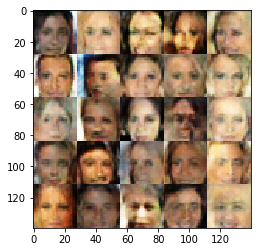


Epoch 1/1 and iteration 2000 The discriminator Loss is 1.535... The generator Loss is 0.539

Epoch 1/1 and iteration 2010 The discriminator Loss is 1.535... The generator Loss is 0.569

Epoch 1/1 and iteration 2020 The discriminator Loss is 1.423... The generator Loss is 0.831

Epoch 1/1 and iteration 2030 The discriminator Loss is 1.637... The generator Loss is 0.401

Epoch 1/1 and iteration 2040 The discriminator Loss is 1.602... The generator Loss is 0.652

Epoch 1/1 and iteration 2050 The discriminator Loss is 1.477... The generator Loss is 0.670

Epoch 1/1 and iteration 2060 The discriminator Loss is 1.620... The generator Loss is 0.657

Epoch 1/1 and iteration 2070 The discriminator Loss is 1.489... The generator Loss is 0.633

Epoch 1/1 and iteration 2080 The discriminator Loss is 1.689... The generator Loss is 0.450

Epoch 1/1 and iteration 2090 The discriminator Loss is 1.550... The generator Loss is 0.737


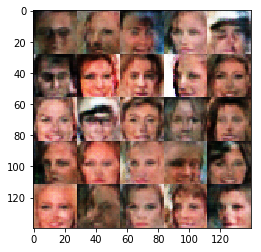


Epoch 1/1 and iteration 2100 The discriminator Loss is 1.572... The generator Loss is 0.544

Epoch 1/1 and iteration 2110 The discriminator Loss is 1.621... The generator Loss is 0.401

Epoch 1/1 and iteration 2120 The discriminator Loss is 1.531... The generator Loss is 0.552

Epoch 1/1 and iteration 2130 The discriminator Loss is 1.584... The generator Loss is 0.473

Epoch 1/1 and iteration 2140 The discriminator Loss is 1.504... The generator Loss is 0.607

Epoch 1/1 and iteration 2150 The discriminator Loss is 1.479... The generator Loss is 0.722

Epoch 1/1 and iteration 2160 The discriminator Loss is 1.496... The generator Loss is 0.616

Epoch 1/1 and iteration 2170 The discriminator Loss is 1.618... The generator Loss is 0.472

Epoch 1/1 and iteration 2180 The discriminator Loss is 1.574... The generator Loss is 0.612

Epoch 1/1 and iteration 2190 The discriminator Loss is 1.449... The generator Loss is 0.714


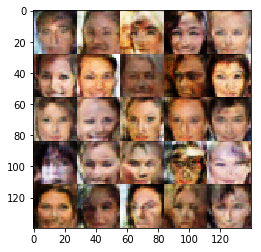


Epoch 1/1 and iteration 2200 The discriminator Loss is 1.628... The generator Loss is 0.511

Epoch 1/1 and iteration 2210 The discriminator Loss is 1.442... The generator Loss is 0.909

Epoch 1/1 and iteration 2220 The discriminator Loss is 1.548... The generator Loss is 0.656

Epoch 1/1 and iteration 2230 The discriminator Loss is 1.812... The generator Loss is 0.311

Epoch 1/1 and iteration 2240 The discriminator Loss is 1.428... The generator Loss is 0.633

Epoch 1/1 and iteration 2250 The discriminator Loss is 1.575... The generator Loss is 0.501

Epoch 1/1 and iteration 2260 The discriminator Loss is 1.576... The generator Loss is 0.496

Epoch 1/1 and iteration 2270 The discriminator Loss is 1.542... The generator Loss is 0.502

Epoch 1/1 and iteration 2280 The discriminator Loss is 1.542... The generator Loss is 0.569

Epoch 1/1 and iteration 2290 The discriminator Loss is 1.611... The generator Loss is 0.425


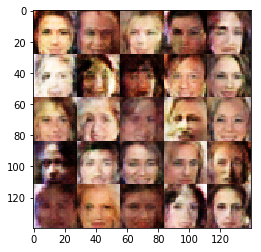


Epoch 1/1 and iteration 2300 The discriminator Loss is 1.634... The generator Loss is 0.467

Epoch 1/1 and iteration 2310 The discriminator Loss is 1.477... The generator Loss is 0.618

Epoch 1/1 and iteration 2320 The discriminator Loss is 1.505... The generator Loss is 0.537

Epoch 1/1 and iteration 2330 The discriminator Loss is 1.676... The generator Loss is 0.471

Epoch 1/1 and iteration 2340 The discriminator Loss is 1.542... The generator Loss is 0.557

Epoch 1/1 and iteration 2350 The discriminator Loss is 1.526... The generator Loss is 0.519

Epoch 1/1 and iteration 2360 The discriminator Loss is 1.549... The generator Loss is 0.547

Epoch 1/1 and iteration 2370 The discriminator Loss is 1.591... The generator Loss is 0.545

Epoch 1/1 and iteration 2380 The discriminator Loss is 1.554... The generator Loss is 0.616

Epoch 1/1 and iteration 2390 The discriminator Loss is 1.656... The generator Loss is 0.372


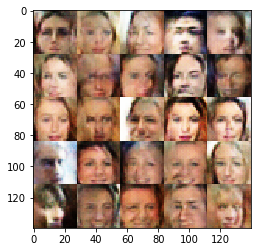


Epoch 1/1 and iteration 2400 The discriminator Loss is 1.549... The generator Loss is 0.469

Epoch 1/1 and iteration 2410 The discriminator Loss is 1.586... The generator Loss is 0.498

Epoch 1/1 and iteration 2420 The discriminator Loss is 1.489... The generator Loss is 0.562

Epoch 1/1 and iteration 2430 The discriminator Loss is 1.570... The generator Loss is 0.486

Epoch 1/1 and iteration 2440 The discriminator Loss is 1.478... The generator Loss is 0.540

Epoch 1/1 and iteration 2450 The discriminator Loss is 1.815... The generator Loss is 0.347

Epoch 1/1 and iteration 2460 The discriminator Loss is 1.555... The generator Loss is 0.535

Epoch 1/1 and iteration 2470 The discriminator Loss is 1.539... The generator Loss is 0.692

Epoch 1/1 and iteration 2480 The discriminator Loss is 1.732... The generator Loss is 0.419

Epoch 1/1 and iteration 2490 The discriminator Loss is 1.711... The generator Loss is 0.397


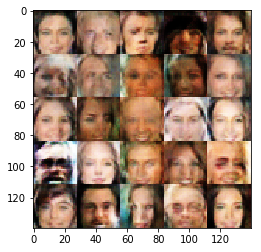


Epoch 1/1 and iteration 2500 The discriminator Loss is 1.638... The generator Loss is 0.484

Epoch 1/1 and iteration 2510 The discriminator Loss is 1.531... The generator Loss is 0.528

Epoch 1/1 and iteration 2520 The discriminator Loss is 1.562... The generator Loss is 0.541

Epoch 1/1 and iteration 2530 The discriminator Loss is 1.512... The generator Loss is 0.582

Epoch 1/1 and iteration 2540 The discriminator Loss is 1.484... The generator Loss is 0.594

Epoch 1/1 and iteration 2550 The discriminator Loss is 1.578... The generator Loss is 0.436

Epoch 1/1 and iteration 2560 The discriminator Loss is 1.620... The generator Loss is 0.442

Epoch 1/1 and iteration 2570 The discriminator Loss is 1.464... The generator Loss is 0.606

Epoch 1/1 and iteration 2580 The discriminator Loss is 1.680... The generator Loss is 0.526

Epoch 1/1 and iteration 2590 The discriminator Loss is 1.651... The generator Loss is 0.429


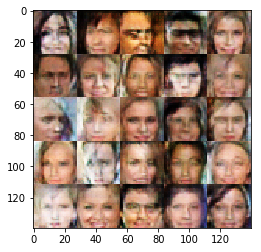


Epoch 1/1 and iteration 2600 The discriminator Loss is 1.553... The generator Loss is 0.598

Epoch 1/1 and iteration 2610 The discriminator Loss is 1.523... The generator Loss is 0.605

Epoch 1/1 and iteration 2620 The discriminator Loss is 1.489... The generator Loss is 0.606

Epoch 1/1 and iteration 2630 The discriminator Loss is 1.720... The generator Loss is 0.385

Epoch 1/1 and iteration 2640 The discriminator Loss is 1.674... The generator Loss is 0.743

Epoch 1/1 and iteration 2650 The discriminator Loss is 1.709... The generator Loss is 0.476

Epoch 1/1 and iteration 2660 The discriminator Loss is 1.496... The generator Loss is 0.759

Epoch 1/1 and iteration 2670 The discriminator Loss is 1.555... The generator Loss is 0.574

Epoch 1/1 and iteration 2680 The discriminator Loss is 1.514... The generator Loss is 0.696

Epoch 1/1 and iteration 2690 The discriminator Loss is 1.578... The generator Loss is 0.577


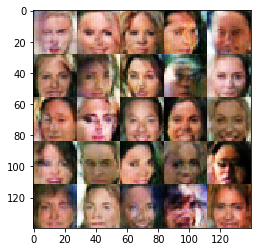


Epoch 1/1 and iteration 2700 The discriminator Loss is 1.629... The generator Loss is 0.534

Epoch 1/1 and iteration 2710 The discriminator Loss is 1.555... The generator Loss is 0.424

Epoch 1/1 and iteration 2720 The discriminator Loss is 1.474... The generator Loss is 0.683

Epoch 1/1 and iteration 2730 The discriminator Loss is 1.541... The generator Loss is 0.566

Epoch 1/1 and iteration 2740 The discriminator Loss is 1.688... The generator Loss is 0.398

Epoch 1/1 and iteration 2750 The discriminator Loss is 1.593... The generator Loss is 0.549

Epoch 1/1 and iteration 2760 The discriminator Loss is 1.723... The generator Loss is 0.419

Epoch 1/1 and iteration 2770 The discriminator Loss is 1.603... The generator Loss is 0.720

Epoch 1/1 and iteration 2780 The discriminator Loss is 1.476... The generator Loss is 0.760

Epoch 1/1 and iteration 2790 The discriminator Loss is 1.865... The generator Loss is 0.350


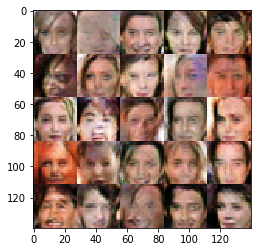


Epoch 1/1 and iteration 2800 The discriminator Loss is 1.549... The generator Loss is 0.519

Epoch 1/1 and iteration 2810 The discriminator Loss is 1.596... The generator Loss is 0.431

Epoch 1/1 and iteration 2820 The discriminator Loss is 1.807... The generator Loss is 0.326

Epoch 1/1 and iteration 2830 The discriminator Loss is 1.395... The generator Loss is 0.916

Epoch 1/1 and iteration 2840 The discriminator Loss is 1.600... The generator Loss is 0.560

Epoch 1/1 and iteration 2850 The discriminator Loss is 1.487... The generator Loss is 0.602

Epoch 1/1 and iteration 2860 The discriminator Loss is 1.490... The generator Loss is 0.576

Epoch 1/1 and iteration 2870 The discriminator Loss is 1.621... The generator Loss is 0.433

Epoch 1/1 and iteration 2880 The discriminator Loss is 1.534... The generator Loss is 0.567

Epoch 1/1 and iteration 2890 The discriminator Loss is 1.303... The generator Loss is 0.687


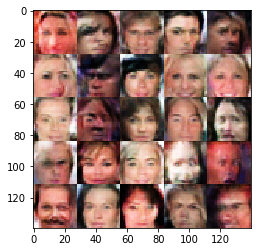


Epoch 1/1 and iteration 2900 The discriminator Loss is 1.768... The generator Loss is 0.357

Epoch 1/1 and iteration 2910 The discriminator Loss is 1.586... The generator Loss is 0.651

Epoch 1/1 and iteration 2920 The discriminator Loss is 1.671... The generator Loss is 0.408

Epoch 1/1 and iteration 2930 The discriminator Loss is 1.603... The generator Loss is 0.494

Epoch 1/1 and iteration 2940 The discriminator Loss is 1.556... The generator Loss is 0.501

Epoch 1/1 and iteration 2950 The discriminator Loss is 1.590... The generator Loss is 0.532

Epoch 1/1 and iteration 2960 The discriminator Loss is 1.656... The generator Loss is 0.407

Epoch 1/1 and iteration 2970 The discriminator Loss is 1.684... The generator Loss is 0.359

Epoch 1/1 and iteration 2980 The discriminator Loss is 1.533... The generator Loss is 0.507

Epoch 1/1 and iteration 2990 The discriminator Loss is 1.587... The generator Loss is 0.496


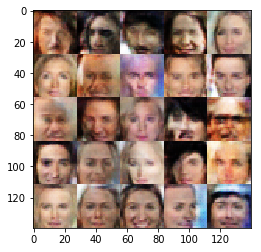


Epoch 1/1 and iteration 3000 The discriminator Loss is 1.553... The generator Loss is 0.509

Epoch 1/1 and iteration 3010 The discriminator Loss is 1.434... The generator Loss is 0.643

Epoch 1/1 and iteration 3020 The discriminator Loss is 1.635... The generator Loss is 0.453

Epoch 1/1 and iteration 3030 The discriminator Loss is 1.531... The generator Loss is 0.548

Epoch 1/1 and iteration 3040 The discriminator Loss is 1.630... The generator Loss is 0.392

Epoch 1/1 and iteration 3050 The discriminator Loss is 1.487... The generator Loss is 0.650

Epoch 1/1 and iteration 3060 The discriminator Loss is 1.491... The generator Loss is 0.506

Epoch 1/1 and iteration 3070 The discriminator Loss is 1.554... The generator Loss is 0.535

Epoch 1/1 and iteration 3080 The discriminator Loss is 1.552... The generator Loss is 0.516

Epoch 1/1 and iteration 3090 The discriminator Loss is 1.607... The generator Loss is 0.521


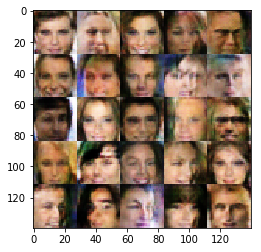


Epoch 1/1 and iteration 3100 The discriminator Loss is 1.739... The generator Loss is 0.382

Epoch 1/1 and iteration 3110 The discriminator Loss is 1.547... The generator Loss is 0.494

Epoch 1/1 and iteration 3120 The discriminator Loss is 1.568... The generator Loss is 0.612

Epoch 1/1 and iteration 3130 The discriminator Loss is 1.802... The generator Loss is 0.301

Epoch 1/1 and iteration 3140 The discriminator Loss is 1.526... The generator Loss is 0.659

Epoch 1/1 and iteration 3150 The discriminator Loss is 1.654... The generator Loss is 0.451

Epoch 1/1 and iteration 3160 The discriminator Loss is 1.659... The generator Loss is 0.592

Epoch 1/1 and iteration 3170 The discriminator Loss is 1.776... The generator Loss is 0.351

Epoch 1/1 and iteration 3180 The discriminator Loss is 1.391... The generator Loss is 0.866

Epoch 1/1 and iteration 3190 The discriminator Loss is 1.505... The generator Loss is 0.484


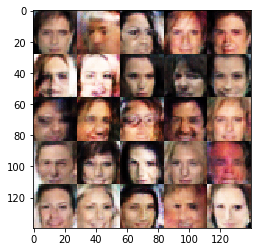


Epoch 1/1 and iteration 3200 The discriminator Loss is 1.507... The generator Loss is 0.548

Epoch 1/1 and iteration 3210 The discriminator Loss is 1.679... The generator Loss is 0.383

Epoch 1/1 and iteration 3220 The discriminator Loss is 1.510... The generator Loss is 0.702

Epoch 1/1 and iteration 3230 The discriminator Loss is 1.496... The generator Loss is 0.548

Epoch 1/1 and iteration 3240 The discriminator Loss is 1.802... The generator Loss is 0.335

Epoch 1/1 and iteration 3250 The discriminator Loss is 1.634... The generator Loss is 0.386

Epoch 1/1 and iteration 3260 The discriminator Loss is 1.676... The generator Loss is 0.429

Epoch 1/1 and iteration 3270 The discriminator Loss is 1.707... The generator Loss is 0.527

Epoch 1/1 and iteration 3280 The discriminator Loss is 1.663... The generator Loss is 0.407

Epoch 1/1 and iteration 3290 The discriminator Loss is 1.593... The generator Loss is 0.650


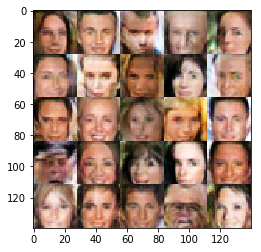


Epoch 1/1 and iteration 3300 The discriminator Loss is 1.589... The generator Loss is 0.611

Epoch 1/1 and iteration 3310 The discriminator Loss is 1.555... The generator Loss is 0.670

Epoch 1/1 and iteration 3320 The discriminator Loss is 1.546... The generator Loss is 0.568

Epoch 1/1 and iteration 3330 The discriminator Loss is 1.846... The generator Loss is 0.472

Epoch 1/1 and iteration 3340 The discriminator Loss is 1.621... The generator Loss is 0.484

Epoch 1/1 and iteration 3350 The discriminator Loss is 1.584... The generator Loss is 0.519

Epoch 1/1 and iteration 3360 The discriminator Loss is 1.563... The generator Loss is 0.523

Epoch 1/1 and iteration 3370 The discriminator Loss is 1.519... The generator Loss is 0.508

Epoch 1/1 and iteration 3380 The discriminator Loss is 1.663... The generator Loss is 0.490

Epoch 1/1 and iteration 3390 The discriminator Loss is 1.501... The generator Loss is 0.716


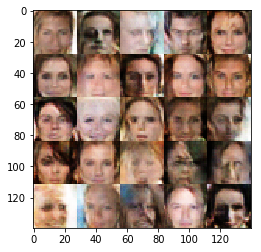


Epoch 1/1 and iteration 3400 The discriminator Loss is 1.607... The generator Loss is 0.599

Epoch 1/1 and iteration 3410 The discriminator Loss is 1.634... The generator Loss is 0.431

Epoch 1/1 and iteration 3420 The discriminator Loss is 1.497... The generator Loss is 0.473

Epoch 1/1 and iteration 3430 The discriminator Loss is 1.707... The generator Loss is 0.390

Epoch 1/1 and iteration 3440 The discriminator Loss is 1.455... The generator Loss is 0.676

Epoch 1/1 and iteration 3450 The discriminator Loss is 1.437... The generator Loss is 0.548

Epoch 1/1 and iteration 3460 The discriminator Loss is 1.593... The generator Loss is 0.461

Epoch 1/1 and iteration 3470 The discriminator Loss is 1.586... The generator Loss is 0.564

Epoch 1/1 and iteration 3480 The discriminator Loss is 1.646... The generator Loss is 0.400

Epoch 1/1 and iteration 3490 The discriminator Loss is 1.728... The generator Loss is 0.445


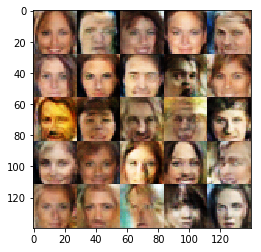


Epoch 1/1 and iteration 3500 The discriminator Loss is 1.456... The generator Loss is 0.744

Epoch 1/1 and iteration 3510 The discriminator Loss is 1.419... The generator Loss is 0.545

Epoch 1/1 and iteration 3520 The discriminator Loss is 1.746... The generator Loss is 0.408

Epoch 1/1 and iteration 3530 The discriminator Loss is 1.574... The generator Loss is 0.469

Epoch 1/1 and iteration 3540 The discriminator Loss is 1.478... The generator Loss is 0.573

Epoch 1/1 and iteration 3550 The discriminator Loss is 1.520... The generator Loss is 0.447

Epoch 1/1 and iteration 3560 The discriminator Loss is 1.619... The generator Loss is 0.434

Epoch 1/1 and iteration 3570 The discriminator Loss is 1.555... The generator Loss is 0.534

Epoch 1/1 and iteration 3580 The discriminator Loss is 1.688... The generator Loss is 0.347

Epoch 1/1 and iteration 3590 The discriminator Loss is 1.449... The generator Loss is 0.505


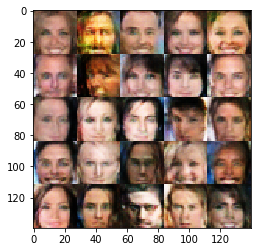


Epoch 1/1 and iteration 3600 The discriminator Loss is 1.297... The generator Loss is 0.735

Epoch 1/1 and iteration 3610 The discriminator Loss is 1.856... The generator Loss is 0.315

Epoch 1/1 and iteration 3620 The discriminator Loss is 1.725... The generator Loss is 0.440

Epoch 1/1 and iteration 3630 The discriminator Loss is 1.701... The generator Loss is 0.381

Epoch 1/1 and iteration 3640 The discriminator Loss is 1.633... The generator Loss is 0.423

Epoch 1/1 and iteration 3650 The discriminator Loss is 1.640... The generator Loss is 0.430

Epoch 1/1 and iteration 3660 The discriminator Loss is 1.538... The generator Loss is 0.575

Epoch 1/1 and iteration 3670 The discriminator Loss is 1.786... The generator Loss is 0.572

Epoch 1/1 and iteration 3680 The discriminator Loss is 1.685... The generator Loss is 0.658

Epoch 1/1 and iteration 3690 The discriminator Loss is 1.927... The generator Loss is 0.258


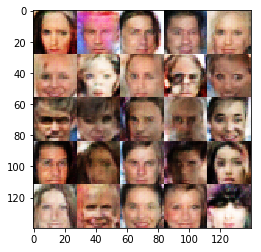


Epoch 1/1 and iteration 3700 The discriminator Loss is 1.540... The generator Loss is 0.707

Epoch 1/1 and iteration 3710 The discriminator Loss is 1.496... The generator Loss is 0.565

Epoch 1/1 and iteration 3720 The discriminator Loss is 1.520... The generator Loss is 0.534

Epoch 1/1 and iteration 3730 The discriminator Loss is 1.518... The generator Loss is 0.465

Epoch 1/1 and iteration 3740 The discriminator Loss is 1.510... The generator Loss is 0.465

Epoch 1/1 and iteration 3750 The discriminator Loss is 1.585... The generator Loss is 0.490

Epoch 1/1 and iteration 3760 The discriminator Loss is 1.612... The generator Loss is 0.676

Epoch 1/1 and iteration 3770 The discriminator Loss is 1.515... The generator Loss is 0.768

Epoch 1/1 and iteration 3780 The discriminator Loss is 1.633... The generator Loss is 0.447

Epoch 1/1 and iteration 3790 The discriminator Loss is 1.503... The generator Loss is 0.597


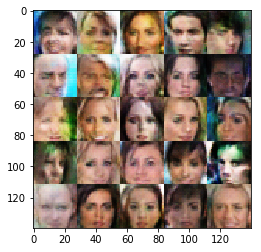


Epoch 1/1 and iteration 3800 The discriminator Loss is 1.657... The generator Loss is 0.390

Epoch 1/1 and iteration 3810 The discriminator Loss is 1.425... The generator Loss is 0.599

Epoch 1/1 and iteration 3820 The discriminator Loss is 1.720... The generator Loss is 0.450

Epoch 1/1 and iteration 3830 The discriminator Loss is 1.834... The generator Loss is 0.305

Epoch 1/1 and iteration 3840 The discriminator Loss is 1.599... The generator Loss is 0.486

Epoch 1/1 and iteration 3850 The discriminator Loss is 1.953... The generator Loss is 0.297

Epoch 1/1 and iteration 3860 The discriminator Loss is 1.653... The generator Loss is 0.397

Epoch 1/1 and iteration 3870 The discriminator Loss is 1.549... The generator Loss is 0.478

Epoch 1/1 and iteration 3880 The discriminator Loss is 1.673... The generator Loss is 0.385

Epoch 1/1 and iteration 3890 The discriminator Loss is 1.623... The generator Loss is 0.490


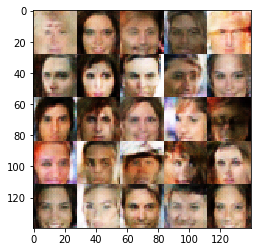


Epoch 1/1 and iteration 3900 The discriminator Loss is 1.556... The generator Loss is 0.470

Epoch 1/1 and iteration 3910 The discriminator Loss is 1.721... The generator Loss is 0.359

Epoch 1/1 and iteration 3920 The discriminator Loss is 1.643... The generator Loss is 0.435

Epoch 1/1 and iteration 3930 The discriminator Loss is 1.699... The generator Loss is 0.375

Epoch 1/1 and iteration 3940 The discriminator Loss is 1.444... The generator Loss is 0.599

Epoch 1/1 and iteration 3950 The discriminator Loss is 1.600... The generator Loss is 0.435

Epoch 1/1 and iteration 3960 The discriminator Loss is 1.446... The generator Loss is 0.587

Epoch 1/1 and iteration 3970 The discriminator Loss is 1.372... The generator Loss is 0.766

Epoch 1/1 and iteration 3980 The discriminator Loss is 1.940... The generator Loss is 0.285

Epoch 1/1 and iteration 3990 The discriminator Loss is 1.851... The generator Loss is 0.280


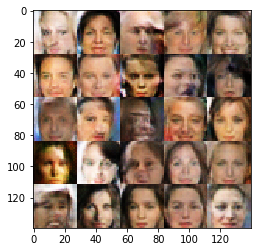


Epoch 1/1 and iteration 4000 The discriminator Loss is 1.973... The generator Loss is 0.288

Epoch 1/1 and iteration 4010 The discriminator Loss is 1.561... The generator Loss is 0.637

Epoch 1/1 and iteration 4020 The discriminator Loss is 1.919... The generator Loss is 0.303

Epoch 1/1 and iteration 4030 The discriminator Loss is 1.299... The generator Loss is 0.961

Epoch 1/1 and iteration 4040 The discriminator Loss is 1.415... The generator Loss is 0.728

Epoch 1/1 and iteration 4050 The discriminator Loss is 1.844... The generator Loss is 0.330

Epoch 1/1 and iteration 4060 The discriminator Loss is 1.624... The generator Loss is 0.512

Epoch 1/1 and iteration 4070 The discriminator Loss is 1.802... The generator Loss is 0.315

Epoch 1/1 and iteration 4080 The discriminator Loss is 1.430... The generator Loss is 0.736

Epoch 1/1 and iteration 4090 The discriminator Loss is 1.546... The generator Loss is 0.443


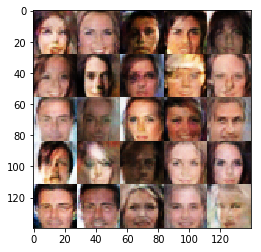


Epoch 1/1 and iteration 4100 The discriminator Loss is 1.404... The generator Loss is 0.623

Epoch 1/1 and iteration 4110 The discriminator Loss is 1.851... The generator Loss is 0.333

Epoch 1/1 and iteration 4120 The discriminator Loss is 1.604... The generator Loss is 0.437

Epoch 1/1 and iteration 4130 The discriminator Loss is 1.807... The generator Loss is 0.325

Epoch 1/1 and iteration 4140 The discriminator Loss is 1.498... The generator Loss is 0.504

Epoch 1/1 and iteration 4150 The discriminator Loss is 1.544... The generator Loss is 0.454

Epoch 1/1 and iteration 4160 The discriminator Loss is 1.572... The generator Loss is 0.581

Epoch 1/1 and iteration 4170 The discriminator Loss is 1.825... The generator Loss is 0.327

Epoch 1/1 and iteration 4180 The discriminator Loss is 1.694... The generator Loss is 0.358

Epoch 1/1 and iteration 4190 The discriminator Loss is 1.542... The generator Loss is 0.460


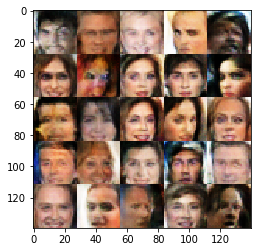


Epoch 1/1 and iteration 4200 The discriminator Loss is 1.618... The generator Loss is 0.417

Epoch 1/1 and iteration 4210 The discriminator Loss is 1.668... The generator Loss is 0.419

Epoch 1/1 and iteration 4220 The discriminator Loss is 1.286... The generator Loss is 0.723

Epoch 1/1 and iteration 4230 The discriminator Loss is 1.790... The generator Loss is 0.322

Epoch 1/1 and iteration 4240 The discriminator Loss is 2.167... The generator Loss is 0.203

Epoch 1/1 and iteration 4250 The discriminator Loss is 1.562... The generator Loss is 0.417

Epoch 1/1 and iteration 4260 The discriminator Loss is 1.717... The generator Loss is 0.367

Epoch 1/1 and iteration 4270 The discriminator Loss is 1.703... The generator Loss is 0.392

Epoch 1/1 and iteration 4280 The discriminator Loss is 1.579... The generator Loss is 0.505

Epoch 1/1 and iteration 4290 The discriminator Loss is 1.856... The generator Loss is 0.346


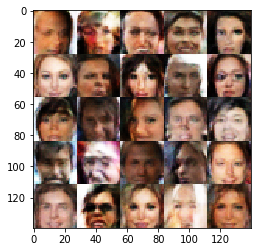


Epoch 1/1 and iteration 4300 The discriminator Loss is 1.638... The generator Loss is 0.424

Epoch 1/1 and iteration 4310 The discriminator Loss is 1.686... The generator Loss is 0.364

Epoch 1/1 and iteration 4320 The discriminator Loss is 1.413... The generator Loss is 0.632

Epoch 1/1 and iteration 4330 The discriminator Loss is 1.713... The generator Loss is 0.436

Epoch 1/1 and iteration 4340 The discriminator Loss is 1.716... The generator Loss is 0.362

Epoch 1/1 and iteration 4350 The discriminator Loss is 1.911... The generator Loss is 0.289

Epoch 1/1 and iteration 4360 The discriminator Loss is 1.844... The generator Loss is 0.312

Epoch 1/1 and iteration 4370 The discriminator Loss is 1.527... The generator Loss is 0.553

Epoch 1/1 and iteration 4380 The discriminator Loss is 1.669... The generator Loss is 0.547

Epoch 1/1 and iteration 4390 The discriminator Loss is 1.537... The generator Loss is 0.598


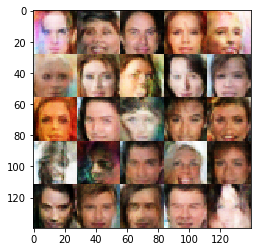


Epoch 1/1 and iteration 4400 The discriminator Loss is 1.910... The generator Loss is 0.273

Epoch 1/1 and iteration 4410 The discriminator Loss is 1.755... The generator Loss is 0.343

Epoch 1/1 and iteration 4420 The discriminator Loss is 1.631... The generator Loss is 0.412

Epoch 1/1 and iteration 4430 The discriminator Loss is 1.810... The generator Loss is 0.327

Epoch 1/1 and iteration 4440 The discriminator Loss is 1.480... The generator Loss is 0.662

Epoch 1/1 and iteration 4450 The discriminator Loss is 1.775... The generator Loss is 0.310

Epoch 1/1 and iteration 4460 The discriminator Loss is 1.688... The generator Loss is 0.374

Epoch 1/1 and iteration 4470 The discriminator Loss is 1.490... The generator Loss is 0.599

Epoch 1/1 and iteration 4480 The discriminator Loss is 1.339... The generator Loss is 0.629

Epoch 1/1 and iteration 4490 The discriminator Loss is 1.651... The generator Loss is 0.423


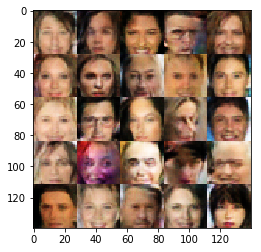


Epoch 1/1 and iteration 4500 The discriminator Loss is 1.591... The generator Loss is 0.441

Epoch 1/1 and iteration 4510 The discriminator Loss is 1.402... The generator Loss is 0.729

Epoch 1/1 and iteration 4520 The discriminator Loss is 1.566... The generator Loss is 0.629

Epoch 1/1 and iteration 4530 The discriminator Loss is 1.338... The generator Loss is 0.777

Epoch 1/1 and iteration 4540 The discriminator Loss is 1.571... The generator Loss is 0.508

Epoch 1/1 and iteration 4550 The discriminator Loss is 1.565... The generator Loss is 0.457

Epoch 1/1 and iteration 4560 The discriminator Loss is 1.724... The generator Loss is 0.362

Epoch 1/1 and iteration 4570 The discriminator Loss is 1.485... The generator Loss is 0.576

Epoch 1/1 and iteration 4580 The discriminator Loss is 1.558... The generator Loss is 0.604

Epoch 1/1 and iteration 4590 The discriminator Loss is 1.495... The generator Loss is 0.544


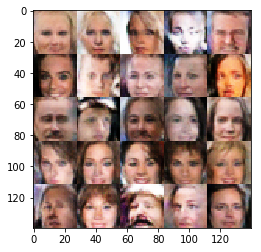


Epoch 1/1 and iteration 4600 The discriminator Loss is 1.642... The generator Loss is 0.384

Epoch 1/1 and iteration 4610 The discriminator Loss is 1.527... The generator Loss is 0.468


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.45


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.